## 1. 모델 정의

### 1-1. 기본 준비

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data1 = pd.read_csv('d01_preprocessed_revised.csv')
data2 = pd.read_csv('d02_preprocessed.csv')
data3 = pd.read_csv('d03_preprocessed.csv')

### 1-2. 데이터 증강 및 구조화

In [ ]:
for idx, i in enumerate(data2['thought']):
    if type(i) != str:
        data2['thought'][idx] = ''

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data2['thought'][idx] = ''
/tmp/ipython-input-3705106326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['thought'][idx] = ''
/tmp/ipython-input-3705106326.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column 

In [ ]:
data1_1 = data1['situation']+' '+data1['thought']
data1_2 = data1['situation']+' '+data1['reframe']
data2_1 = data2['situation']
data3_1 = data3['situation']+' '+data3['thought']
data3_2 = data3['situation']+' '+data3['reframe']

In [ ]:
data1_1.drop_duplicates(inplace = True)
data1_2.drop_duplicates(inplace = True)
data2_1.drop_duplicates(inplace = True)
data3_1.drop_duplicates(inplace = True)
data3_2.drop_duplicates(inplace = True)

In [ ]:
def normalize_text(s):
    # Removing articles and punctuation, and standardizing whitespace
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_config = BertConfig.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Embedding

def tokenize_and_pad(data, tokenizer, max_len=512):
    tokenized_data = []
    for text in data:
        encoded = tokenizer(normalize_text(text), return_tensors = "pt", padding='max_length', truncation=True, max_length=max_len)
        tokenized_data.append(encoded)
    return tokenized_data

data1_1_encoded = tokenize_and_pad(data1_1, tokenizer)
data1_2_encoded = tokenize_and_pad(data1_2, tokenizer)
data2_1_encoded = tokenize_and_pad(data2_1, tokenizer)
data3_1_encoded = tokenize_and_pad(data3_1, tokenizer)
data3_2_encoded = tokenize_and_pad(data3_2, tokenizer)

In [ ]:
# Add labels
data1_1_labels = list(data1['has_distortion'][data1_1.index])
data2_1_labels = list(data2['has_distortion'][data2_1.index])
data3_1_labels = list(data3['has_distortion'][data3_1.index])

data1_2_labels = [0 for i in range(len(data1_2_encoded))]
data3_2_labels = [0 for i in range(len(data3_2_encoded))]

In [ ]:
# Merging Data
data_encoded = data1_1_encoded + data1_2_encoded + data2_1_encoded + data3_1_encoded + data3_2_encoded
data_labels = data1_1_labels + data1_2_labels + data2_1_labels + data3_1_labels + data3_2_labels

In [ ]:
class CustomDatasetWithLabels(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {"input_ids": self.data[idx]['input_ids'].squeeze(),
                "attention_mask": self.data[idx]['attention_mask'].squeeze(),
                "y": self.labels[idx]}

In [ ]:
dataset_with_labels = CustomDatasetWithLabels(data_encoded, data_labels)

# Define proportions for splitting
train_size = int(0.8 * len(dataset_with_labels))
val_size = int(0.1 * len(dataset_with_labels))
test_size = len(dataset_with_labels) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_with_labels, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

input_dim = bert_config.hidden_size
num_labels = len(set(data_labels))
label_emb = torch.randn(num_labels, input_dim)

### 1-3. 모델 평가 함수 정의

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device="cpu"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["y"].to(device)

            # Get embeddings from the BERT model
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

            logits = model(embeddings)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [ ]:
# Classifier that uses label embeddings to make predictions
class InnerProductClassifier(nn.Module):
    def __init__(self, input_dim, label_embeddings, trainable_label_emb=True):
        super().__init__()
        # Project input features into the same dimension as label embeddings
        self.proj = nn.Linear(input_dim, label_embeddings.size(1))

        if trainable_label_emb:
            # Label embeddings are trainable parameters
            self.label_emb = nn.Parameter(label_embeddings.clone())
        else:
            # Label embeddings are fixed (not updated during training)
            self.register_buffer("label_emb", label_embeddings.clone())

    def forward(self, x):
        # Project input feature vectors
        x_proj = self.proj(x)
        # Compute logits as similarity with each label embedding
        logits = torch.matmul(x_proj, self.label_emb.T)
        return logits

### 1-4. 모델 생성

In [ ]:
# Instantiate the InnerProductClassifier model
model = InnerProductClassifier(input_dim, label_emb).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

## 2. 모델 학습

In [ ]:
EPOCHS = 10

# Move the BERT model to the device
bert_model.to(device)

for epoch in range(EPOCHS):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["y"].to(device)

        # Get embeddings from the BERT model
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Pass embeddings to the InnerProductClassifier
        logits = model(embeddings)
        loss = criterion(logits, y)

        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

    # Evaluate on the validation set after each epoch
    val_metrics = evaluate(model, val_dataloader, device)
    print(f"Epoch {epoch} Validation Accuracy: {val_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Epoch 0:   2%|▏         | 1/49 [00:02<01:52,  2.34s/it]

Loss: 1.5905358791351318


Epoch 0:   4%|▍         | 2/49 [00:04<01:31,  1.95s/it]

Loss: 4.11440372467041


Epoch 0:   6%|▌         | 3/49 [00:05<01:24,  1.84s/it]

Loss: 5.963557720184326


Epoch 0:   8%|▊         | 4/49 [00:07<01:20,  1.78s/it]

Loss: 5.2851080894470215


Epoch 0:  10%|█         | 5/49 [00:09<01:17,  1.76s/it]

Loss: 2.7919399738311768


Epoch 0:  12%|█▏        | 6/49 [00:10<01:14,  1.74s/it]

Loss: 2.6590278148651123


Epoch 0:  14%|█▍        | 7/49 [00:12<01:12,  1.73s/it]

Loss: 6.020174980163574


Epoch 0:  16%|█▋        | 8/49 [00:14<01:10,  1.73s/it]

Loss: 3.502279281616211


Epoch 0:  18%|█▊        | 9/49 [00:15<01:09,  1.73s/it]

Loss: 2.326448917388916


Epoch 0:  20%|██        | 10/49 [00:17<01:07,  1.73s/it]

Loss: 3.500889301300049


Epoch 0:  22%|██▏       | 11/49 [00:19<01:05,  1.73s/it]

Loss: 5.538273811340332


Epoch 0:  24%|██▍       | 12/49 [00:21<01:03,  1.73s/it]

Loss: 3.0553712844848633


Epoch 0:  27%|██▋       | 13/49 [00:22<01:02,  1.73s/it]

Loss: 2.502410888671875


Epoch 0:  29%|██▊       | 14/49 [00:24<01:00,  1.73s/it]

Loss: 2.7842936515808105


Epoch 0:  31%|███       | 15/49 [00:26<00:59,  1.74s/it]

Loss: 3.4553890228271484


Epoch 0:  33%|███▎      | 16/49 [00:28<00:57,  1.74s/it]

Loss: 3.552656888961792


Epoch 0:  35%|███▍      | 17/49 [00:29<00:56,  1.75s/it]

Loss: 2.2528839111328125


Epoch 0:  37%|███▋      | 18/49 [00:31<00:54,  1.76s/it]

Loss: 3.0752718448638916


Epoch 0:  39%|███▉      | 19/49 [00:33<00:53,  1.77s/it]

Loss: 3.487898826599121


Epoch 0:  41%|████      | 20/49 [00:35<00:51,  1.78s/it]

Loss: 4.6531453132629395


Epoch 0:  43%|████▎     | 21/49 [00:37<00:49,  1.79s/it]

Loss: 2.885925769805908


Epoch 0:  45%|████▍     | 22/49 [00:38<00:48,  1.79s/it]

Loss: 2.113933563232422


Epoch 0:  47%|████▋     | 23/49 [00:40<00:46,  1.80s/it]

Loss: 3.1574137210845947


Epoch 0:  49%|████▉     | 24/49 [00:42<00:45,  1.82s/it]

Loss: 2.2682583332061768


Epoch 0:  51%|█████     | 25/49 [00:44<00:43,  1.83s/it]

Loss: 0.9033069014549255


Epoch 0:  53%|█████▎    | 26/49 [00:46<00:42,  1.83s/it]

Loss: 1.9940619468688965


Epoch 0:  55%|█████▌    | 27/49 [00:48<00:40,  1.83s/it]

Loss: 3.5836377143859863


Epoch 0:  57%|█████▋    | 28/49 [00:49<00:38,  1.84s/it]

Loss: 1.9637737274169922


Epoch 0:  59%|█████▉    | 29/49 [00:51<00:36,  1.85s/it]

Loss: 1.2719237804412842


Epoch 0:  61%|██████    | 30/49 [00:53<00:35,  1.86s/it]

Loss: 2.040778160095215


Epoch 0:  63%|██████▎   | 31/49 [00:55<00:33,  1.86s/it]

Loss: 2.3859548568725586


Epoch 0:  65%|██████▌   | 32/49 [00:57<00:31,  1.87s/it]

Loss: 2.277024030685425


Epoch 0:  67%|██████▋   | 33/49 [00:59<00:29,  1.87s/it]

Loss: 1.774742603302002


Epoch 0:  69%|██████▉   | 34/49 [01:01<00:28,  1.88s/it]

Loss: 2.749603271484375


Epoch 0:  71%|███████▏  | 35/49 [01:03<00:26,  1.89s/it]

Loss: 2.5489768981933594


Epoch 0:  73%|███████▎  | 36/49 [01:05<00:24,  1.89s/it]

Loss: 1.5806753635406494


Epoch 0:  76%|███████▌  | 37/49 [01:07<00:22,  1.90s/it]

Loss: 1.9570201635360718


Epoch 0:  78%|███████▊  | 38/49 [01:08<00:21,  1.91s/it]

Loss: 1.6237337589263916


Epoch 0:  80%|███████▉  | 39/49 [01:10<00:19,  1.93s/it]

Loss: 2.347903251647949


Epoch 0:  82%|████████▏ | 40/49 [01:12<00:17,  1.93s/it]

Loss: 1.2055681943893433


Epoch 0:  84%|████████▎ | 41/49 [01:14<00:15,  1.94s/it]

Loss: 1.8626832962036133


Epoch 0:  86%|████████▌ | 42/49 [01:16<00:13,  1.96s/it]

Loss: 1.7672531604766846


Epoch 0:  88%|████████▊ | 43/49 [01:18<00:11,  1.97s/it]

Loss: 1.0244338512420654


Epoch 0:  90%|████████▉ | 44/49 [01:20<00:09,  1.98s/it]

Loss: 1.5953441858291626


Epoch 0:  92%|█████████▏| 45/49 [01:22<00:07,  1.99s/it]

Loss: 1.2772682905197144


Epoch 0:  94%|█████████▍| 46/49 [01:24<00:06,  2.01s/it]

Loss: 1.2810204029083252


Epoch 0:  96%|█████████▌| 47/49 [01:26<00:04,  2.02s/it]

Loss: 1.3711498975753784


Epoch 0:  98%|█████████▊| 48/49 [01:28<00:02,  2.03s/it]

Loss: 1.646704912185669


Epoch 0: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.9928030371665955


Epoch 0 Validation Accuracy: 0.7305699481865285, F1-macro: 0.7255899160582944


Epoch 1:   2%|▏         | 1/49 [00:02<01:36,  2.02s/it]

Loss: 1.071557641029358


Epoch 1:   4%|▍         | 2/49 [00:04<01:34,  2.02s/it]

Loss: 0.8110867738723755


Epoch 1:   6%|▌         | 3/49 [00:06<01:32,  2.02s/it]

Loss: 0.8689318895339966


Epoch 1:   8%|▊         | 4/49 [00:08<01:30,  2.02s/it]

Loss: 0.6359915733337402


Epoch 1:  10%|█         | 5/49 [00:10<01:28,  2.02s/it]

Loss: 0.7605223655700684


Epoch 1:  12%|█▏        | 6/49 [00:12<01:26,  2.01s/it]

Loss: 1.1222680807113647


Epoch 1:  14%|█▍        | 7/49 [00:14<01:24,  2.01s/it]

Loss: 1.7278574705123901


Epoch 1:  16%|█▋        | 8/49 [00:16<01:22,  2.00s/it]

Loss: 1.8555256128311157


Epoch 1:  18%|█▊        | 9/49 [00:18<01:19,  2.00s/it]

Loss: 1.1045087575912476


Epoch 1:  20%|██        | 10/49 [00:20<01:17,  1.99s/it]

Loss: 0.9273911118507385


Epoch 1:  22%|██▏       | 11/49 [00:22<01:15,  1.99s/it]

Loss: 0.9466161727905273


Epoch 1:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 0.8427978754043579


Epoch 1:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 1.2673592567443848


Epoch 1:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 0.6838979721069336


Epoch 1:  31%|███       | 15/49 [00:29<01:07,  1.97s/it]

Loss: 1.4334423542022705


Epoch 1:  33%|███▎      | 16/49 [00:31<01:05,  1.97s/it]

Loss: 0.8119406700134277


Epoch 1:  35%|███▍      | 17/49 [00:33<01:02,  1.97s/it]

Loss: 1.5459561347961426


Epoch 1:  37%|███▋      | 18/49 [00:35<01:01,  1.97s/it]

Loss: 0.8635168075561523


Epoch 1:  39%|███▉      | 19/49 [00:37<00:58,  1.96s/it]

Loss: 0.9070446491241455


Epoch 1:  41%|████      | 20/49 [00:39<00:56,  1.96s/it]

Loss: 1.4275262355804443


Epoch 1:  43%|████▎     | 21/49 [00:41<00:54,  1.96s/it]

Loss: 1.2805322408676147


Epoch 1:  45%|████▍     | 22/49 [00:43<00:52,  1.96s/it]

Loss: 1.8148398399353027


Epoch 1:  47%|████▋     | 23/49 [00:45<00:50,  1.96s/it]

Loss: 0.9376257658004761


Epoch 1:  49%|████▉     | 24/49 [00:47<00:48,  1.96s/it]

Loss: 1.2500641345977783


Epoch 1:  51%|█████     | 25/49 [00:49<00:46,  1.96s/it]

Loss: 0.9663608074188232


Epoch 1:  53%|█████▎    | 26/49 [00:51<00:45,  1.96s/it]

Loss: 0.8163056373596191


Epoch 1:  55%|█████▌    | 27/49 [00:53<00:43,  1.96s/it]

Loss: 0.8823782205581665


Epoch 1:  57%|█████▋    | 28/49 [00:55<00:41,  1.96s/it]

Loss: 0.7909961342811584


Epoch 1:  59%|█████▉    | 29/49 [00:57<00:39,  1.96s/it]

Loss: 0.8296117186546326


Epoch 1:  61%|██████    | 30/49 [00:59<00:37,  1.96s/it]

Loss: 0.564407467842102


Epoch 1:  63%|██████▎   | 31/49 [01:01<00:35,  1.96s/it]

Loss: 1.0250134468078613


Epoch 1:  65%|██████▌   | 32/49 [01:03<00:33,  1.96s/it]

Loss: 0.4677426815032959


Epoch 1:  67%|██████▋   | 33/49 [01:05<00:31,  1.97s/it]

Loss: 0.8395023941993713


Epoch 1:  69%|██████▉   | 34/49 [01:07<00:29,  1.97s/it]

Loss: 0.5774577260017395


Epoch 1:  71%|███████▏  | 35/49 [01:09<00:27,  1.97s/it]

Loss: 0.7493282556533813


Epoch 1:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 0.5019814968109131


Epoch 1:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 0.7900416254997253


Epoch 1:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 0.5408596396446228


Epoch 1:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.9107561707496643


Epoch 1:  82%|████████▏ | 40/49 [01:19<00:17,  1.99s/it]

Loss: 0.6660901308059692


Epoch 1:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 1.6464192867279053


Epoch 1:  86%|████████▌ | 42/49 [01:23<00:13,  1.99s/it]

Loss: 0.9058374166488647


Epoch 1:  88%|████████▊ | 43/49 [01:25<00:11,  1.99s/it]

Loss: 1.236339807510376


Epoch 1:  90%|████████▉ | 44/49 [01:27<00:09,  1.99s/it]

Loss: 0.9029858708381653


Epoch 1:  92%|█████████▏| 45/49 [01:29<00:07,  1.99s/it]

Loss: 0.67998206615448


Epoch 1:  94%|█████████▍| 46/49 [01:31<00:05,  1.99s/it]

Loss: 0.7217309474945068


Epoch 1:  96%|█████████▌| 47/49 [01:33<00:03,  1.99s/it]

Loss: 1.0458601713180542


Epoch 1:  98%|█████████▊| 48/49 [01:35<00:01,  1.99s/it]

Loss: 0.7166690230369568


Epoch 1: 100%|██████████| 49/49 [01:35<00:00,  1.95s/it]

Loss: 0.8090528845787048


Epoch 1 Validation Accuracy: 0.6632124352331606, F1-macro: 0.656987395072868


Epoch 2:   2%|▏         | 1/49 [00:01<01:34,  1.98s/it]

Loss: 0.7469711899757385


Epoch 2:   4%|▍         | 2/49 [00:03<01:33,  1.99s/it]

Loss: 0.7166027426719666


Epoch 2:   6%|▌         | 3/49 [00:05<01:31,  1.99s/it]

Loss: 1.1242129802703857


Epoch 2:   8%|▊         | 4/49 [00:07<01:29,  1.99s/it]

Loss: 0.5440496206283569


Epoch 2:  10%|█         | 5/49 [00:09<01:27,  1.99s/it]

Loss: 1.1581635475158691


Epoch 2:  12%|█▏        | 6/49 [00:11<01:25,  1.99s/it]

Loss: 0.5459451079368591


Epoch 2:  14%|█▍        | 7/49 [00:13<01:23,  1.99s/it]

Loss: 0.9787890911102295


Epoch 2:  16%|█▋        | 8/49 [00:15<01:21,  1.99s/it]

Loss: 0.800473690032959


Epoch 2:  18%|█▊        | 9/49 [00:17<01:19,  1.99s/it]

Loss: 1.2335877418518066


Epoch 2:  20%|██        | 10/49 [00:19<01:17,  1.98s/it]

Loss: 1.7406870126724243


Epoch 2:  22%|██▏       | 11/49 [00:21<01:15,  1.98s/it]

Loss: 1.2478611469268799


Epoch 2:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 2.1512255668640137


Epoch 2:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.7374340891838074


Epoch 2:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 1.4177474975585938


Epoch 2:  31%|███       | 15/49 [00:29<01:07,  1.98s/it]

Loss: 1.0131473541259766


Epoch 2:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 1.0981040000915527


Epoch 2:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.9027284979820251


Epoch 2:  37%|███▋      | 18/49 [00:35<01:01,  1.98s/it]

Loss: 0.6240146160125732


Epoch 2:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 1.2813160419464111


Epoch 2:  41%|████      | 20/49 [00:39<00:57,  1.98s/it]

Loss: 0.8631622195243835


Epoch 2:  43%|████▎     | 21/49 [00:41<00:55,  1.98s/it]

Loss: 0.8641893863677979


Epoch 2:  45%|████▍     | 22/49 [00:43<00:53,  1.98s/it]

Loss: 1.2958542108535767


Epoch 2:  47%|████▋     | 23/49 [00:45<00:51,  1.98s/it]

Loss: 1.2020378112792969


Epoch 2:  49%|████▉     | 24/49 [00:47<00:49,  1.98s/it]

Loss: 0.6857185363769531


Epoch 2:  51%|█████     | 25/49 [00:49<00:47,  1.98s/it]

Loss: 1.533528447151184


Epoch 2:  53%|█████▎    | 26/49 [00:51<00:45,  1.97s/it]

Loss: 0.8184711337089539


Epoch 2:  55%|█████▌    | 27/49 [00:53<00:43,  1.97s/it]

Loss: 1.109354853630066


Epoch 2:  57%|█████▋    | 28/49 [00:55<00:41,  1.97s/it]

Loss: 0.969422459602356


Epoch 2:  59%|█████▉    | 29/49 [00:57<00:39,  1.97s/it]

Loss: 0.97702956199646


Epoch 2:  61%|██████    | 30/49 [00:59<00:37,  1.97s/it]

Loss: 0.8141580820083618


Epoch 2:  63%|██████▎   | 31/49 [01:01<00:35,  1.97s/it]

Loss: 0.6718349456787109


Epoch 2:  65%|██████▌   | 32/49 [01:03<00:33,  1.97s/it]

Loss: 1.292112946510315


Epoch 2:  67%|██████▋   | 33/49 [01:05<00:31,  1.98s/it]

Loss: 1.1844244003295898


Epoch 2:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 0.867712140083313


Epoch 2:  71%|███████▏  | 35/49 [01:09<00:27,  1.98s/it]

Loss: 1.6164332628250122


Epoch 2:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 1.1744606494903564


Epoch 2:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 1.2325690984725952


Epoch 2:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 1.2636358737945557


Epoch 2:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.7037511467933655


Epoch 2:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 1.4223304986953735


Epoch 2:  84%|████████▎ | 41/49 [01:21<00:15,  1.98s/it]

Loss: 0.7701035141944885


Epoch 2:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.6967648267745972


Epoch 2:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.9740842580795288


Epoch 2:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 0.7364950180053711


Epoch 2:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 1.6877018213272095


Epoch 2:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 0.7531973123550415


Epoch 2:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 1.2014577388763428


Epoch 2:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 1.0871413946151733


Epoch 2: 100%|██████████| 49/49 [01:35<00:00,  1.95s/it]

Loss: 0.6261319518089294


Epoch 2 Validation Accuracy: 0.7046632124352331, F1-macro: 0.703517046220186


Epoch 3:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.9996116161346436


Epoch 3:   4%|▍         | 2/49 [00:03<01:32,  1.98s/it]

Loss: 0.8402583003044128


Epoch 3:   6%|▌         | 3/49 [00:05<01:31,  1.98s/it]

Loss: 1.1696314811706543


Epoch 3:   8%|▊         | 4/49 [00:07<01:29,  1.98s/it]

Loss: 0.5872131586074829


Epoch 3:  10%|█         | 5/49 [00:09<01:27,  1.98s/it]

Loss: 0.6576570272445679


Epoch 3:  12%|█▏        | 6/49 [00:11<01:25,  1.98s/it]

Loss: 0.6019186973571777


Epoch 3:  14%|█▍        | 7/49 [00:13<01:23,  1.98s/it]

Loss: 0.6068094968795776


Epoch 3:  16%|█▋        | 8/49 [00:15<01:21,  1.98s/it]

Loss: 1.2658977508544922


Epoch 3:  18%|█▊        | 9/49 [00:17<01:19,  1.98s/it]

Loss: 0.8977273106575012


Epoch 3:  20%|██        | 10/49 [00:19<01:17,  1.99s/it]

Loss: 0.557786226272583


Epoch 3:  22%|██▏       | 11/49 [00:21<01:15,  1.99s/it]

Loss: 0.9406037926673889


Epoch 3:  24%|██▍       | 12/49 [00:23<01:13,  1.99s/it]

Loss: 0.7024843692779541


Epoch 3:  27%|██▋       | 13/49 [00:25<01:11,  1.99s/it]

Loss: 0.5911381840705872


Epoch 3:  29%|██▊       | 14/49 [00:27<01:09,  1.99s/it]

Loss: 0.610059916973114


Epoch 3:  31%|███       | 15/49 [00:29<01:07,  1.99s/it]

Loss: 0.7739657163619995


Epoch 3:  33%|███▎      | 16/49 [00:31<01:05,  1.99s/it]

Loss: 0.6606119871139526


Epoch 3:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.7033038139343262


Epoch 3:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 0.7897168397903442


Epoch 3:  39%|███▉      | 19/49 [00:37<00:59,  1.99s/it]

Loss: 0.8566426634788513


Epoch 3:  41%|████      | 20/49 [00:39<00:57,  1.98s/it]

Loss: 0.547417402267456


Epoch 3:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 0.7787061929702759


Epoch 3:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 0.9552118182182312


Epoch 3:  47%|████▋     | 23/49 [00:45<00:51,  1.98s/it]

Loss: 0.729191780090332


Epoch 3:  49%|████▉     | 24/49 [00:47<00:49,  1.98s/it]

Loss: 0.578152060508728


Epoch 3:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.6735096573829651


Epoch 3:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 0.6589133739471436


Epoch 3:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 0.7305303812026978


Epoch 3:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.8663160800933838


Epoch 3:  59%|█████▉    | 29/49 [00:57<00:39,  1.99s/it]

Loss: 0.5589059591293335


Epoch 3:  61%|██████    | 30/49 [00:59<00:37,  1.99s/it]

Loss: 0.7351258397102356


Epoch 3:  63%|██████▎   | 31/49 [01:01<00:35,  1.99s/it]

Loss: 0.5497789978981018


Epoch 3:  65%|██████▌   | 32/49 [01:03<00:33,  1.99s/it]

Loss: 0.49084800481796265


Epoch 3:  67%|██████▋   | 33/49 [01:05<00:31,  1.99s/it]

Loss: 0.7480376362800598


Epoch 3:  69%|██████▉   | 34/49 [01:07<00:29,  1.99s/it]

Loss: 0.513253390789032


Epoch 3:  71%|███████▏  | 35/49 [01:09<00:27,  1.99s/it]

Loss: 0.8636367321014404


Epoch 3:  73%|███████▎  | 36/49 [01:11<00:25,  1.99s/it]

Loss: 0.6622076630592346


Epoch 3:  76%|███████▌  | 37/49 [01:13<00:23,  1.99s/it]

Loss: 0.6284737586975098


Epoch 3:  78%|███████▊  | 38/49 [01:15<00:21,  1.99s/it]

Loss: 0.8667310476303101


Epoch 3:  80%|███████▉  | 39/49 [01:17<00:19,  1.99s/it]

Loss: 0.6846218109130859


Epoch 3:  82%|████████▏ | 40/49 [01:19<00:17,  1.99s/it]

Loss: 0.8493800759315491


Epoch 3:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 0.43722599744796753


Epoch 3:  86%|████████▌ | 42/49 [01:23<00:13,  1.99s/it]

Loss: 0.9179275631904602


Epoch 3:  88%|████████▊ | 43/49 [01:25<00:11,  1.99s/it]

Loss: 0.6033182144165039


Epoch 3:  90%|████████▉ | 44/49 [01:27<00:09,  1.99s/it]

Loss: 0.5514824390411377


Epoch 3:  92%|█████████▏| 45/49 [01:29<00:07,  1.99s/it]

Loss: 0.8214126229286194


Epoch 3:  94%|█████████▍| 46/49 [01:31<00:05,  1.99s/it]

Loss: 0.9165555834770203


Epoch 3:  96%|█████████▌| 47/49 [01:33<00:03,  1.99s/it]

Loss: 0.7442836165428162


Epoch 3:  98%|█████████▊| 48/49 [01:35<00:01,  1.99s/it]

Loss: 1.342459797859192


Epoch 3: 100%|██████████| 49/49 [01:35<00:00,  1.96s/it]

Loss: 0.6530969142913818


Epoch 3 Validation Accuracy: 0.7046632124352331, F1-macro: 0.6907051282051282


Epoch 4:   2%|▏         | 1/49 [00:01<01:35,  1.98s/it]

Loss: 0.8883949518203735


Epoch 4:   4%|▍         | 2/49 [00:03<01:33,  1.99s/it]

Loss: 1.21590256690979


Epoch 4:   6%|▌         | 3/49 [00:05<01:31,  1.99s/it]

Loss: 0.835935115814209


Epoch 4:   8%|▊         | 4/49 [00:07<01:29,  1.99s/it]

Loss: 0.589276909828186


Epoch 4:  10%|█         | 5/49 [00:09<01:27,  1.99s/it]

Loss: 0.8956246972084045


Epoch 4:  12%|█▏        | 6/49 [00:11<01:25,  1.99s/it]

Loss: 0.38440680503845215


Epoch 4:  14%|█▍        | 7/49 [00:13<01:23,  1.99s/it]

Loss: 0.9103140830993652


Epoch 4:  16%|█▋        | 8/49 [00:15<01:21,  1.99s/it]

Loss: 0.6641378998756409


Epoch 4:  18%|█▊        | 9/49 [00:17<01:19,  1.99s/it]

Loss: 0.4917997419834137


Epoch 4:  20%|██        | 10/49 [00:19<01:17,  1.99s/it]

Loss: 0.5376524925231934


Epoch 4:  22%|██▏       | 11/49 [00:21<01:15,  1.99s/it]

Loss: 0.46707773208618164


Epoch 4:  24%|██▍       | 12/49 [00:23<01:13,  1.99s/it]

Loss: 0.8106840252876282


Epoch 4:  27%|██▋       | 13/49 [00:25<01:11,  1.99s/it]

Loss: 0.7249415516853333


Epoch 4:  29%|██▊       | 14/49 [00:27<01:09,  1.99s/it]

Loss: 0.6009798049926758


Epoch 4:  31%|███       | 15/49 [00:29<01:07,  1.99s/it]

Loss: 0.7623535394668579


Epoch 4:  33%|███▎      | 16/49 [00:31<01:05,  1.99s/it]

Loss: 0.5756565928459167


Epoch 4:  35%|███▍      | 17/49 [00:33<01:03,  1.99s/it]

Loss: 1.2866320610046387


Epoch 4:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 1.2150732278823853


Epoch 4:  39%|███▉      | 19/49 [00:37<00:59,  1.99s/it]

Loss: 0.5059072971343994


Epoch 4:  41%|████      | 20/49 [00:39<00:57,  1.99s/it]

Loss: 1.2565128803253174


Epoch 4:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 0.6544376611709595


Epoch 4:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 1.1799365282058716


Epoch 4:  47%|████▋     | 23/49 [00:45<00:51,  1.99s/it]

Loss: 0.43674567341804504


Epoch 4:  49%|████▉     | 24/49 [00:47<00:49,  1.99s/it]

Loss: 0.6440253257751465


Epoch 4:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.9199600219726562


Epoch 4:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 0.7657763957977295


Epoch 4:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 2.2025461196899414


Epoch 4:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.42924875020980835


Epoch 4:  59%|█████▉    | 29/49 [00:57<00:39,  1.99s/it]

Loss: 1.6452049016952515


Epoch 4:  61%|██████    | 30/49 [00:59<00:37,  1.99s/it]

Loss: 0.9393370151519775


Epoch 4:  63%|██████▎   | 31/49 [01:01<00:35,  1.99s/it]

Loss: 1.1685469150543213


Epoch 4:  65%|██████▌   | 32/49 [01:03<00:33,  1.99s/it]

Loss: 0.9982069730758667


Epoch 4:  67%|██████▋   | 33/49 [01:05<00:31,  1.99s/it]

Loss: 0.6719765663146973


Epoch 4:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 0.902256190776825


Epoch 4:  71%|███████▏  | 35/49 [01:09<00:27,  1.98s/it]

Loss: 0.7087464332580566


Epoch 4:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 0.7207118272781372


Epoch 4:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 0.6492838263511658


Epoch 4:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 0.997870683670044


Epoch 4:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.6196904182434082


Epoch 4:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 0.7645792961120605


Epoch 4:  84%|████████▎ | 41/49 [01:21<00:15,  1.98s/it]

Loss: 0.6362448334693909


Epoch 4:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.7746472358703613


Epoch 4:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.3763280212879181


Epoch 4:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 1.2049508094787598


Epoch 4:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 0.7632157206535339


Epoch 4:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 1.3203049898147583


Epoch 4:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 0.715638279914856


Epoch 4:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 1.5178558826446533


Epoch 4: 100%|██████████| 49/49 [01:35<00:00,  1.96s/it]

Loss: 1.1502572298049927


Epoch 4 Validation Accuracy: 0.6347150259067358, F1-macro: 0.6160992022345896


Epoch 5:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 1.384531855583191


Epoch 5:   4%|▍         | 2/49 [00:03<01:33,  1.98s/it]

Loss: 2.5449230670928955


Epoch 5:   6%|▌         | 3/49 [00:05<01:31,  1.99s/it]

Loss: 1.0772807598114014


Epoch 5:   8%|▊         | 4/49 [00:07<01:29,  1.99s/it]

Loss: 2.529426097869873


Epoch 5:  10%|█         | 5/49 [00:09<01:27,  1.99s/it]

Loss: 1.7201284170150757


Epoch 5:  12%|█▏        | 6/49 [00:11<01:25,  1.99s/it]

Loss: 0.7793618440628052


Epoch 5:  14%|█▍        | 7/49 [00:13<01:23,  1.99s/it]

Loss: 0.7307321429252625


Epoch 5:  16%|█▋        | 8/49 [00:15<01:21,  1.99s/it]

Loss: 0.7733668684959412


Epoch 5:  18%|█▊        | 9/49 [00:17<01:19,  1.99s/it]

Loss: 0.6022337675094604


Epoch 5:  20%|██        | 10/49 [00:19<01:17,  1.99s/it]

Loss: 1.5063581466674805


Epoch 5:  22%|██▏       | 11/49 [00:21<01:15,  2.00s/it]

Loss: 0.9184149503707886


Epoch 5:  24%|██▍       | 12/49 [00:23<01:13,  2.00s/it]

Loss: 0.7225843667984009


Epoch 5:  27%|██▋       | 13/49 [00:25<01:11,  1.99s/it]

Loss: 1.1233651638031006


Epoch 5:  29%|██▊       | 14/49 [00:27<01:09,  1.99s/it]

Loss: 0.6395463347434998


Epoch 5:  31%|███       | 15/49 [00:29<01:07,  1.99s/it]

Loss: 1.5067720413208008


Epoch 5:  33%|███▎      | 16/49 [00:31<01:05,  1.99s/it]

Loss: 0.9288320541381836


Epoch 5:  35%|███▍      | 17/49 [00:33<01:03,  1.99s/it]

Loss: 0.8998774290084839


Epoch 5:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 0.9365577697753906


Epoch 5:  39%|███▉      | 19/49 [00:37<00:59,  1.99s/it]

Loss: 0.7465780973434448


Epoch 5:  41%|████      | 20/49 [00:39<00:57,  1.99s/it]

Loss: 1.6433297395706177


Epoch 5:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 1.3227921724319458


Epoch 5:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 0.9146502017974854


Epoch 5:  47%|████▋     | 23/49 [00:45<00:51,  1.99s/it]

Loss: 0.841926634311676


Epoch 5:  49%|████▉     | 24/49 [00:47<00:49,  1.99s/it]

Loss: 1.8811544179916382


Epoch 5:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.9994250535964966


Epoch 5:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 1.2263262271881104


Epoch 5:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 0.7883763313293457


Epoch 5:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.4010795056819916


Epoch 5:  59%|█████▉    | 29/49 [00:57<00:39,  1.99s/it]

Loss: 1.1328390836715698


Epoch 5:  61%|██████    | 30/49 [00:59<00:37,  1.99s/it]

Loss: 0.6652910113334656


Epoch 5:  63%|██████▎   | 31/49 [01:01<00:35,  1.99s/it]

Loss: 0.7683755159378052


Epoch 5:  65%|██████▌   | 32/49 [01:03<00:33,  1.99s/it]

Loss: 0.38816237449645996


Epoch 5:  67%|██████▋   | 33/49 [01:05<00:31,  1.99s/it]

Loss: 0.8526020646095276


Epoch 5:  69%|██████▉   | 34/49 [01:07<00:29,  1.99s/it]

Loss: 0.6634524464607239


Epoch 5:  71%|███████▏  | 35/49 [01:09<00:27,  1.99s/it]

Loss: 0.8565526008605957


Epoch 5:  73%|███████▎  | 36/49 [01:11<00:25,  1.99s/it]

Loss: 0.7956027388572693


Epoch 5:  76%|███████▌  | 37/49 [01:13<00:23,  1.99s/it]

Loss: 0.7644913196563721


Epoch 5:  78%|███████▊  | 38/49 [01:15<00:21,  1.99s/it]

Loss: 1.0253678560256958


Epoch 5:  80%|███████▉  | 39/49 [01:17<00:19,  1.99s/it]

Loss: 0.6992171406745911


Epoch 5:  82%|████████▏ | 40/49 [01:19<00:17,  1.99s/it]

Loss: 0.5490660667419434


Epoch 5:  84%|████████▎ | 41/49 [01:21<00:15,  1.98s/it]

Loss: 0.5944979190826416


Epoch 5:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.6965000033378601


Epoch 5:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.4129416048526764


Epoch 5:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 0.6480964422225952


Epoch 5:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 0.4843406677246094


Epoch 5:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 0.7342542409896851


Epoch 5:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 0.6198334693908691


Epoch 5:  98%|█████████▊| 48/49 [01:35<00:01,  1.99s/it]

Loss: 0.5369631052017212


Epoch 5: 100%|██████████| 49/49 [01:36<00:00,  1.96s/it]

Loss: 0.8101752400398254


Epoch 5 Validation Accuracy: 0.655440414507772, F1-macro: 0.6460107428271977


Epoch 6:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.9814905524253845


Epoch 6:   4%|▍         | 2/49 [00:03<01:32,  1.98s/it]

Loss: 0.6472761034965515


Epoch 6:   6%|▌         | 3/49 [00:05<01:31,  1.98s/it]

Loss: 0.9556084871292114


Epoch 6:   8%|▊         | 4/49 [00:07<01:29,  1.98s/it]

Loss: 0.6832215189933777


Epoch 6:  10%|█         | 5/49 [00:09<01:27,  1.98s/it]

Loss: 0.6751015186309814


Epoch 6:  12%|█▏        | 6/49 [00:11<01:25,  1.98s/it]

Loss: 0.5073733925819397


Epoch 6:  14%|█▍        | 7/49 [00:13<01:23,  1.98s/it]

Loss: 0.6796848773956299


Epoch 6:  16%|█▋        | 8/49 [00:15<01:21,  1.98s/it]

Loss: 0.48370328545570374


Epoch 6:  18%|█▊        | 9/49 [00:17<01:19,  1.98s/it]

Loss: 0.7366930246353149


Epoch 6:  20%|██        | 10/49 [00:19<01:17,  1.98s/it]

Loss: 0.7825871706008911


Epoch 6:  22%|██▏       | 11/49 [00:21<01:15,  1.98s/it]

Loss: 0.3707621693611145


Epoch 6:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 0.7863831520080566


Epoch 6:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.7403409481048584


Epoch 6:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 0.68085777759552


Epoch 6:  31%|███       | 15/49 [00:29<01:07,  1.98s/it]

Loss: 0.6125102639198303


Epoch 6:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 0.5850500464439392


Epoch 6:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.7358741760253906


Epoch 6:  37%|███▋      | 18/49 [00:35<01:01,  1.98s/it]

Loss: 0.42758551239967346


Epoch 6:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 0.3472820520401001


Epoch 6:  41%|████      | 20/49 [00:39<00:57,  1.98s/it]

Loss: 0.7165614366531372


Epoch 6:  43%|████▎     | 21/49 [00:41<00:55,  1.98s/it]

Loss: 0.32031872868537903


Epoch 6:  45%|████▍     | 22/49 [00:43<00:53,  1.98s/it]

Loss: 0.38818520307540894


Epoch 6:  47%|████▋     | 23/49 [00:45<00:51,  1.98s/it]

Loss: 0.4077630639076233


Epoch 6:  49%|████▉     | 24/49 [00:47<00:49,  1.98s/it]

Loss: 0.4885912537574768


Epoch 6:  51%|█████     | 25/49 [00:49<00:47,  1.98s/it]

Loss: 0.6332204937934875


Epoch 6:  53%|█████▎    | 26/49 [00:51<00:45,  1.98s/it]

Loss: 0.6854544281959534


Epoch 6:  55%|█████▌    | 27/49 [00:53<00:43,  1.98s/it]

Loss: 0.7227526307106018


Epoch 6:  57%|█████▋    | 28/49 [00:55<00:41,  1.98s/it]

Loss: 0.9680463075637817


Epoch 6:  59%|█████▉    | 29/49 [00:57<00:39,  1.98s/it]

Loss: 0.8012787103652954


Epoch 6:  61%|██████    | 30/49 [00:59<00:37,  1.98s/it]

Loss: 0.863229513168335


Epoch 6:  63%|██████▎   | 31/49 [01:01<00:35,  1.98s/it]

Loss: 0.44958555698394775


Epoch 6:  65%|██████▌   | 32/49 [01:03<00:33,  1.98s/it]

Loss: 0.5814680457115173


Epoch 6:  67%|██████▋   | 33/49 [01:05<00:31,  1.98s/it]

Loss: 0.4475666284561157


Epoch 6:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 0.5168302059173584


Epoch 6:  71%|███████▏  | 35/49 [01:09<00:27,  1.98s/it]

Loss: 0.7664437890052795


Epoch 6:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 0.592248797416687


Epoch 6:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 0.515911340713501


Epoch 6:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 0.6954428553581238


Epoch 6:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.8071272373199463


Epoch 6:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 0.47027841210365295


Epoch 6:  84%|████████▎ | 41/49 [01:21<00:15,  1.98s/it]

Loss: 0.6136767864227295


Epoch 6:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.5372248888015747


Epoch 6:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.6832854151725769


Epoch 6:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 0.713323175907135


Epoch 6:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 0.49156710505485535


Epoch 6:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 0.5591566562652588


Epoch 6:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 0.7198454737663269


Epoch 6:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 0.7582756876945496


Epoch 6: 100%|██████████| 49/49 [01:35<00:00,  1.95s/it]

Loss: 0.9284116625785828


Epoch 6 Validation Accuracy: 0.7668393782383419, F1-macro: 0.762529735050447


Epoch 7:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.33989644050598145


Epoch 7:   4%|▍         | 2/49 [00:03<01:32,  1.97s/it]

Loss: 0.5321420431137085


Epoch 7:   6%|▌         | 3/49 [00:05<01:31,  1.98s/it]

Loss: 0.8896994590759277


Epoch 7:   8%|▊         | 4/49 [00:07<01:29,  1.98s/it]

Loss: 0.7103831171989441


Epoch 7:  10%|█         | 5/49 [00:09<01:27,  1.98s/it]

Loss: 1.5799566507339478


Epoch 7:  12%|█▏        | 6/49 [00:11<01:25,  1.98s/it]

Loss: 1.2640001773834229


Epoch 7:  14%|█▍        | 7/49 [00:13<01:23,  1.98s/it]

Loss: 0.4794861972332001


Epoch 7:  16%|█▋        | 8/49 [00:15<01:21,  1.98s/it]

Loss: 0.824364185333252


Epoch 7:  18%|█▊        | 9/49 [00:17<01:19,  1.98s/it]

Loss: 1.1364319324493408


Epoch 7:  20%|██        | 10/49 [00:19<01:17,  1.98s/it]

Loss: 0.9933337569236755


Epoch 7:  22%|██▏       | 11/49 [00:21<01:15,  1.98s/it]

Loss: 0.9100289344787598


Epoch 7:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 0.792578935623169


Epoch 7:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.9814593195915222


Epoch 7:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 0.7071968913078308


Epoch 7:  31%|███       | 15/49 [00:29<01:07,  1.98s/it]

Loss: 1.0452470779418945


Epoch 7:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 0.4799674153327942


Epoch 7:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.9515586495399475


Epoch 7:  37%|███▋      | 18/49 [00:35<01:01,  1.98s/it]

Loss: 0.7217068672180176


Epoch 7:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 0.6159475445747375


Epoch 7:  41%|████      | 20/49 [00:39<00:57,  1.98s/it]

Loss: 0.49730607867240906


Epoch 7:  43%|████▎     | 21/49 [00:41<00:55,  1.98s/it]

Loss: 0.7498767375946045


Epoch 7:  45%|████▍     | 22/49 [00:43<00:53,  1.98s/it]

Loss: 1.215879201889038


Epoch 7:  47%|████▋     | 23/49 [00:45<00:51,  1.98s/it]

Loss: 0.7014275193214417


Epoch 7:  49%|████▉     | 24/49 [00:47<00:49,  1.98s/it]

Loss: 0.8189636468887329


Epoch 7:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.8811917304992676


Epoch 7:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 0.45002126693725586


Epoch 7:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 1.2143962383270264


Epoch 7:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.8525905609130859


Epoch 7:  59%|█████▉    | 29/49 [00:57<00:39,  1.98s/it]

Loss: 0.8737943172454834


Epoch 7:  61%|██████    | 30/49 [00:59<00:37,  1.98s/it]

Loss: 0.7600839138031006


Epoch 7:  63%|██████▎   | 31/49 [01:01<00:35,  1.98s/it]

Loss: 1.3537914752960205


Epoch 7:  65%|██████▌   | 32/49 [01:03<00:33,  1.99s/it]

Loss: 0.32203209400177


Epoch 7:  67%|██████▋   | 33/49 [01:05<00:31,  1.99s/it]

Loss: 0.8624643087387085


Epoch 7:  69%|██████▉   | 34/49 [01:07<00:29,  1.99s/it]

Loss: 0.7312913537025452


Epoch 7:  71%|███████▏  | 35/49 [01:09<00:27,  1.99s/it]

Loss: 0.8112003207206726


Epoch 7:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 1.3080693483352661


Epoch 7:  76%|███████▌  | 37/49 [01:13<00:23,  1.99s/it]

Loss: 1.225234866142273


Epoch 7:  78%|███████▊  | 38/49 [01:15<00:21,  1.99s/it]

Loss: 0.906872034072876


Epoch 7:  80%|███████▉  | 39/49 [01:17<00:19,  1.99s/it]

Loss: 0.3479328751564026


Epoch 7:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 0.7755045294761658


Epoch 7:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 0.720435619354248


Epoch 7:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.9572924971580505


Epoch 7:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.3636546730995178


Epoch 7:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 0.733911395072937


Epoch 7:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 0.42661190032958984


Epoch 7:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 0.7226210236549377


Epoch 7:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 0.7703238725662231


Epoch 7:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 0.4510011374950409


Epoch 7: 100%|██████████| 49/49 [01:35<00:00,  1.95s/it]

Loss: 0.84869384765625


Epoch 7 Validation Accuracy: 0.6968911917098446, F1-macro: 0.6967914761626619


Epoch 8:   2%|▏         | 1/49 [00:01<01:35,  1.98s/it]

Loss: 0.4859926700592041


Epoch 8:   4%|▍         | 2/49 [00:03<01:33,  1.99s/it]

Loss: 0.47259849309921265


Epoch 8:   6%|▌         | 3/49 [00:05<01:31,  1.99s/it]

Loss: 0.8317385911941528


Epoch 8:   8%|▊         | 4/49 [00:07<01:29,  1.98s/it]

Loss: 0.7348023653030396


Epoch 8:  10%|█         | 5/49 [00:09<01:27,  1.99s/it]

Loss: 0.6905360817909241


Epoch 8:  12%|█▏        | 6/49 [00:11<01:25,  1.99s/it]

Loss: 0.6066653728485107


Epoch 8:  14%|█▍        | 7/49 [00:13<01:23,  1.99s/it]

Loss: 0.896274209022522


Epoch 8:  16%|█▋        | 8/49 [00:15<01:21,  1.98s/it]

Loss: 0.3736155033111572


Epoch 8:  18%|█▊        | 9/49 [00:17<01:19,  1.99s/it]

Loss: 0.6772515773773193


Epoch 8:  20%|██        | 10/49 [00:19<01:17,  1.99s/it]

Loss: 0.6114665269851685


Epoch 8:  22%|██▏       | 11/49 [00:21<01:15,  1.99s/it]

Loss: 0.6388483047485352


Epoch 8:  24%|██▍       | 12/49 [00:23<01:13,  1.99s/it]

Loss: 0.4417879283428192


Epoch 8:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.6925304532051086


Epoch 8:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 0.6169623136520386


Epoch 8:  31%|███       | 15/49 [00:29<01:07,  1.99s/it]

Loss: 0.4075968861579895


Epoch 8:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 0.7324108481407166


Epoch 8:  35%|███▍      | 17/49 [00:33<01:03,  1.99s/it]

Loss: 0.7542499899864197


Epoch 8:  37%|███▋      | 18/49 [00:35<01:01,  1.98s/it]

Loss: 0.6091921329498291


Epoch 8:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 0.8845875263214111


Epoch 8:  41%|████      | 20/49 [00:39<00:57,  1.99s/it]

Loss: 1.10804283618927


Epoch 8:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 0.39227837324142456


Epoch 8:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 0.9248331189155579


Epoch 8:  47%|████▋     | 23/49 [00:45<00:51,  1.99s/it]

Loss: 0.8099867105484009


Epoch 8:  49%|████▉     | 24/49 [00:47<00:49,  1.99s/it]

Loss: 0.6191787123680115


Epoch 8:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.5174703001976013


Epoch 8:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 0.6118319034576416


Epoch 8:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 0.9475985169410706


Epoch 8:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.6316074132919312


Epoch 8:  59%|█████▉    | 29/49 [00:57<00:39,  1.99s/it]

Loss: 1.139625072479248


Epoch 8:  61%|██████    | 30/49 [00:59<00:37,  1.99s/it]

Loss: 1.2517547607421875


Epoch 8:  63%|██████▎   | 31/49 [01:01<00:35,  1.99s/it]

Loss: 1.682816982269287


Epoch 8:  65%|██████▌   | 32/49 [01:03<00:33,  1.98s/it]

Loss: 0.8624531030654907


Epoch 8:  67%|██████▋   | 33/49 [01:05<00:31,  1.99s/it]

Loss: 1.0639793872833252


Epoch 8:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 0.9782325625419617


Epoch 8:  71%|███████▏  | 35/49 [01:09<00:27,  1.99s/it]

Loss: 0.6441175937652588


Epoch 8:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 1.8724004030227661


Epoch 8:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 0.6067875027656555


Epoch 8:  78%|███████▊  | 38/49 [01:15<00:21,  1.99s/it]

Loss: 1.320147156715393


Epoch 8:  80%|███████▉  | 39/49 [01:17<00:19,  1.99s/it]

Loss: 0.6843960285186768


Epoch 8:  82%|████████▏ | 40/49 [01:19<00:17,  1.99s/it]

Loss: 0.4626457393169403


Epoch 8:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 0.8655246496200562


Epoch 8:  86%|████████▌ | 42/49 [01:23<00:13,  1.99s/it]

Loss: 0.5171229839324951


Epoch 8:  88%|████████▊ | 43/49 [01:25<00:11,  1.99s/it]

Loss: 1.099642038345337


Epoch 8:  90%|████████▉ | 44/49 [01:27<00:09,  1.99s/it]

Loss: 0.7814546823501587


Epoch 8:  92%|█████████▏| 45/49 [01:29<00:07,  1.99s/it]

Loss: 0.7169504761695862


Epoch 8:  94%|█████████▍| 46/49 [01:31<00:05,  1.99s/it]

Loss: 1.3286678791046143


Epoch 8:  96%|█████████▌| 47/49 [01:33<00:03,  1.99s/it]

Loss: 0.6466346383094788


Epoch 8:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 0.5424243211746216


Epoch 8: 100%|██████████| 49/49 [01:35<00:00,  1.96s/it]

Loss: 0.597080647945404


Epoch 8 Validation Accuracy: 0.7331606217616581, F1-macro: 0.7298076073586277


Epoch 9:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.8058837652206421


Epoch 9:   4%|▍         | 2/49 [00:03<01:32,  1.98s/it]

Loss: 1.4289746284484863


Epoch 9:   6%|▌         | 3/49 [00:05<01:31,  1.98s/it]

Loss: 0.7386208176612854


Epoch 9:   8%|▊         | 4/49 [00:07<01:29,  1.98s/it]

Loss: 0.8337779641151428


Epoch 9:  10%|█         | 5/49 [00:09<01:27,  1.98s/it]

Loss: 0.6185375452041626


Epoch 9:  12%|█▏        | 6/49 [00:11<01:25,  1.98s/it]

Loss: 0.7775253653526306


Epoch 9:  14%|█▍        | 7/49 [00:13<01:23,  1.98s/it]

Loss: 1.1887435913085938


Epoch 9:  16%|█▋        | 8/49 [00:15<01:21,  1.99s/it]

Loss: 0.6434192657470703


Epoch 9:  18%|█▊        | 9/49 [00:17<01:19,  1.98s/it]

Loss: 0.9330494999885559


Epoch 9:  20%|██        | 10/49 [00:19<01:17,  1.98s/it]

Loss: 0.5577818751335144


Epoch 9:  22%|██▏       | 11/49 [00:21<01:15,  1.98s/it]

Loss: 0.6851099729537964


Epoch 9:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 1.4345085620880127


Epoch 9:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.8597570657730103


Epoch 9:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 1.545426845550537


Epoch 9:  31%|███       | 15/49 [00:29<01:07,  1.98s/it]

Loss: 0.8035870790481567


Epoch 9:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 1.56981360912323


Epoch 9:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.8795607089996338


Epoch 9:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 1.0556608438491821


Epoch 9:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 1.8344894647598267


Epoch 9:  41%|████      | 20/49 [00:39<00:57,  1.99s/it]

Loss: 0.5337830185890198


Epoch 9:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 1.6247243881225586


Epoch 9:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 2.8888864517211914


Epoch 9:  47%|████▋     | 23/49 [00:45<00:51,  1.99s/it]

Loss: 1.0581949949264526


Epoch 9:  49%|████▉     | 24/49 [00:47<00:49,  1.99s/it]

Loss: 3.651092052459717


Epoch 9:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.9575336575508118


Epoch 9:  53%|█████▎    | 26/49 [00:51<00:45,  1.98s/it]

Loss: 0.9778509736061096


Epoch 9:  55%|█████▌    | 27/49 [00:53<00:43,  1.98s/it]

Loss: 1.5660483837127686


Epoch 9:  57%|█████▋    | 28/49 [00:55<00:41,  1.98s/it]

Loss: 1.1050608158111572


Epoch 9:  59%|█████▉    | 29/49 [00:57<00:39,  1.98s/it]

Loss: 1.102469801902771


Epoch 9:  61%|██████    | 30/49 [00:59<00:37,  1.98s/it]

Loss: 1.4028875827789307


Epoch 9:  63%|██████▎   | 31/49 [01:01<00:35,  1.98s/it]

Loss: 0.9339179396629333


Epoch 9:  65%|██████▌   | 32/49 [01:03<00:33,  1.98s/it]

Loss: 1.2708580493927002


Epoch 9:  67%|██████▋   | 33/49 [01:05<00:31,  1.98s/it]

Loss: 1.0321274995803833


Epoch 9:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 1.5470993518829346


Epoch 9:  71%|███████▏  | 35/49 [01:09<00:27,  1.99s/it]

Loss: 1.021307349205017


Epoch 9:  73%|███████▎  | 36/49 [01:11<00:25,  1.99s/it]

Loss: 1.209478497505188


Epoch 9:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 1.335005283355713


Epoch 9:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 0.8759545087814331


Epoch 9:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.9041957855224609


Epoch 9:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 1.0551953315734863


Epoch 9:  84%|████████▎ | 41/49 [01:21<00:15,  1.98s/it]

Loss: 1.0167181491851807


Epoch 9:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.8215538263320923


Epoch 9:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.7310042381286621


Epoch 9:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 0.6122725009918213


Epoch 9:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 1.0462400913238525


Epoch 9:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 0.5595009326934814


Epoch 9:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 1.4107513427734375


Epoch 9:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 0.5657758116722107


Epoch 9: 100%|██████████| 49/49 [01:35<00:00,  1.95s/it]

Loss: 1.0429471731185913


Epoch 9 Validation Accuracy: 0.6917098445595855, F1-macro: 0.6878359735502593


## 3. 모델 테스트

In [ ]:
# Evaluate on the test set
test_metrics = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Test Accuracy: 0.6356589147286822, F1-macro: 0.6878359735502593


## 4. 결과 분석 및 의의(시각화)

### 4-1. MDS 시각화

#### 4-1-1. 데이터셋

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Use the combined encoded data and labels
all_encoded_data = data_encoded # This is already a list of dictionaries from previous steps
all_labels = data_labels # This is the combined list of labels

# Create a DataLoader for all data
all_dataset = CustomDatasetWithLabels(all_encoded_data, all_labels)
all_dataloader = DataLoader(all_dataset, batch_size=64)

# Get embeddings from the BERT model
bert_model.eval()
all_embeddings = []
with torch.no_grad():
    for batch in tqdm(all_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(embeddings.cpu())

all_embeddings = torch.cat(all_embeddings)

# Compute similarity and distance matrices
similarity_matrix = cosine_similarity(all_embeddings.numpy())
distance_matrix = 1 - similarity_matrix

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
mds_result = mds.fit_transform(distance_matrix)

100%|██████████| 61/61 [01:59<00:00,  1.96s/it]


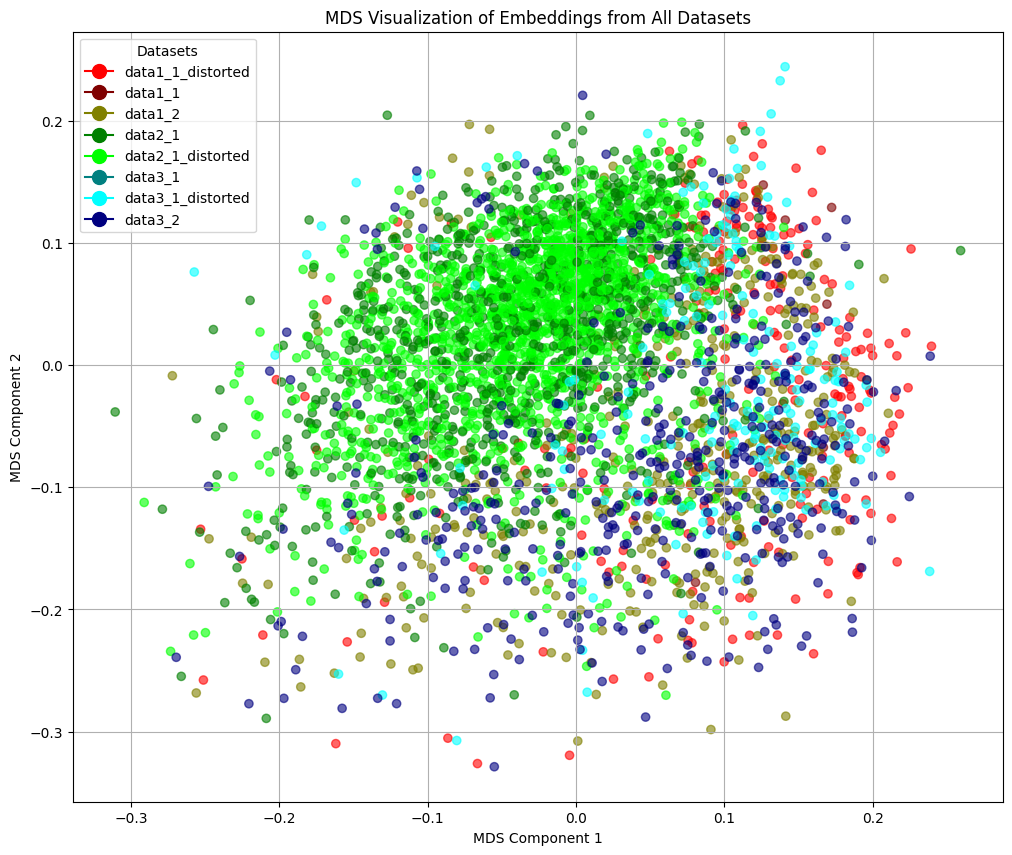

In [ ]:
# All cases
# Get the original dataset indices for coloring
data1_1_len = len(data1_1_encoded)
data1_2_len = len(data1_2_encoded)
data2_1_len = len(data2_1_encoded)
data3_1_len = len(data3_1_encoded)
data3_2_len = len(data3_2_encoded)

dataset_indices = []
dataset_indices += [(0.5*x+0.5, 0, 0) for x in data1_1_labels] # data1_1
dataset_indices += [(0.5, 0.5, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, 0.5*x+0.5, 0) for x in data2_1_labels] # data2_1
dataset_indices += [(0, 0.5*x+0.5, 0.5*x+0.5) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 0.5) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(1, 0, 0), label='data1_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0.5, 0, 0), label='data1_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0.5, 0.5, 0), label='data1_2', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0.5, 0), label='data2_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 0), label='data2_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0.5, 0.5), label='data3_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 1), label='data3_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 0.5), label='data3_2', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

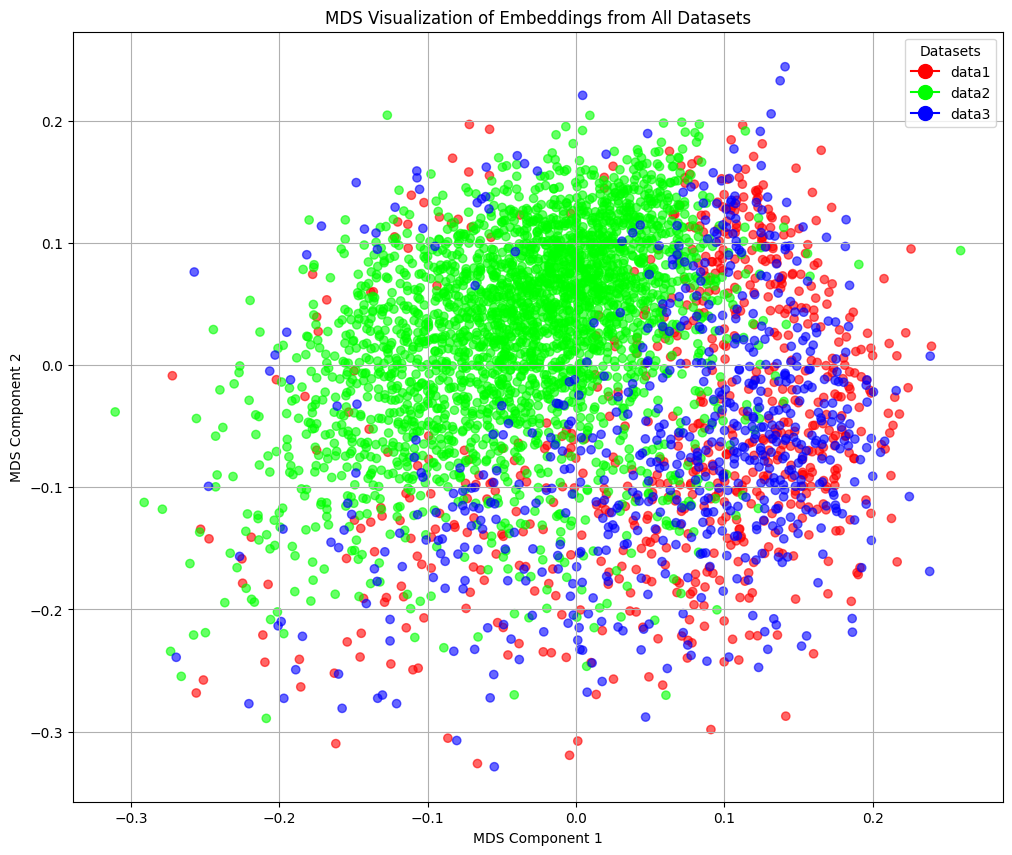

In [ ]:
# Comparing data - source
# Get the original dataset indices for coloring
dataset_indices = []
dataset_indices += [(1, 0, 0) for x in data1_1_labels] # data1_1
dataset_indices += [(1, 0, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, 1, 0) for x in data2_1_labels] # data2_1
dataset_indices += [(0, 0, 1) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 1) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(1, 0, 0), label='data1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 0), label='data2', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 1), label='data3', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

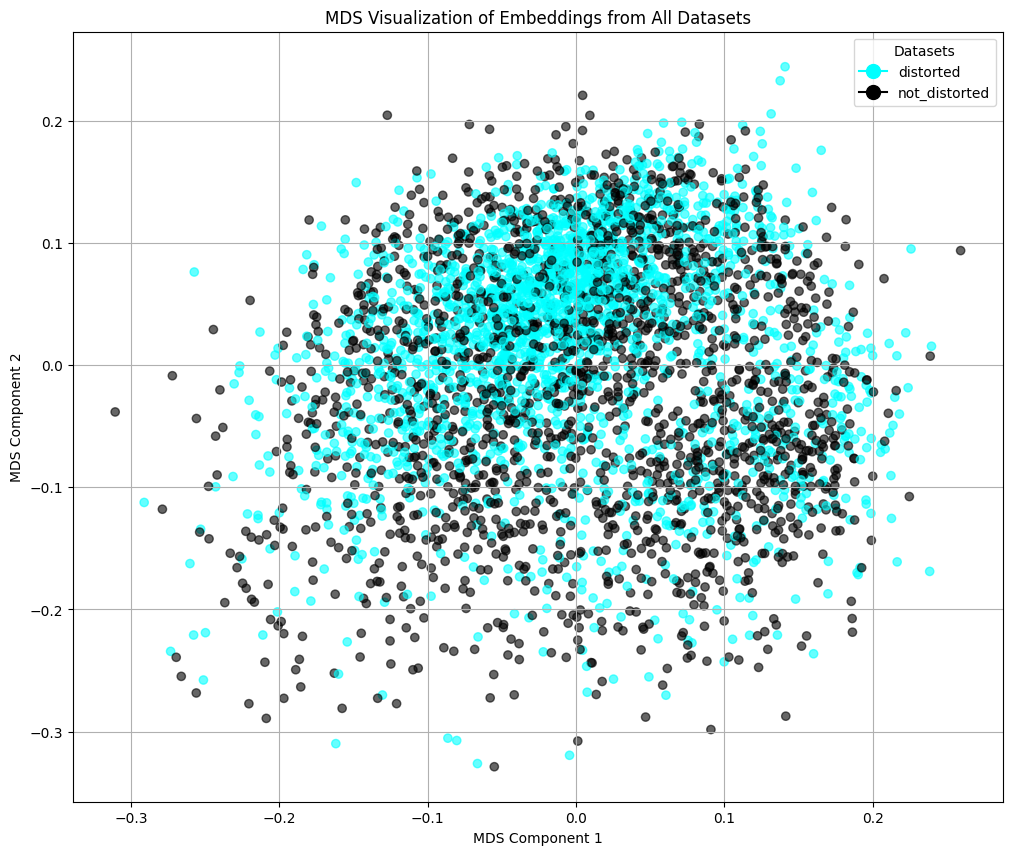

In [ ]:
# Comparing data - distortedness
# Get the original dataset indices for coloring
data1_1_len = len(data1_1_encoded)
data1_2_len = len(data1_2_encoded)
data2_1_len = len(data2_1_encoded)
data3_1_len = len(data3_1_encoded)
data3_2_len = len(data3_2_encoded)

dataset_indices = []
dataset_indices += [(0, x, x) for x in data1_1_labels] # data1_1
dataset_indices += [(0, 0, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, x, x) for x in data2_1_labels] # data2_1
dataset_indices += [(0, x, x) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 0) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(0, 1, 1), label='distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 0), label='not_distorted', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

#### 4-1-2. 잠재 벡터

In [ ]:
# latent vector
print(model.label_emb)

Parameter containing:
tensor([[ 0.5130,  0.3447, -0.9448,  ..., -1.2585,  2.0301,  2.1085],
        [ 1.1162,  0.7165,  0.8434,  ...,  1.1401, -0.0892,  0.5215]],
       device='cuda:0', requires_grad=True)


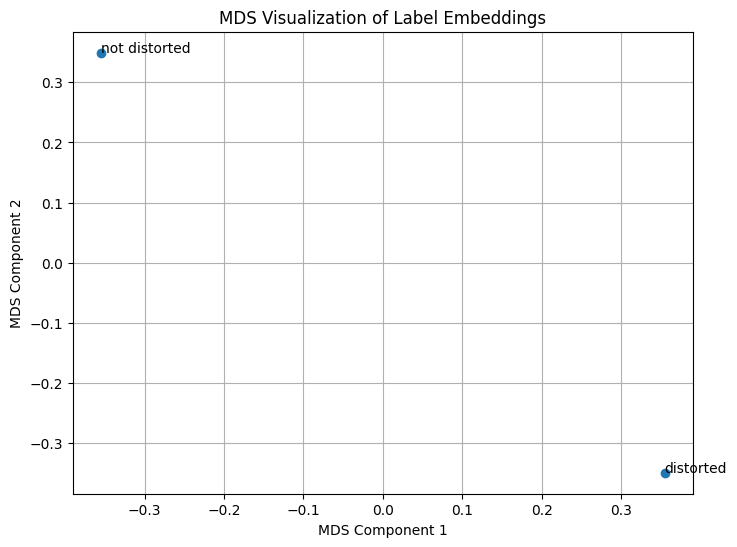

In [ ]:
# Get the label embeddings
label_embeddings = model.label_emb.detach().cpu().numpy()

# Compute similarity and distance matrices
similarity_matrix_labels = cosine_similarity(label_embeddings)
distance_matrix_labels = 1 - similarity_matrix_labels

# Perform MDS on label embeddings
mds_labels = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
mds_result_labels = mds_labels.fit_transform(distance_matrix_labels)

# Get the labels for plotting (0 and 1 in this case)
labels_for_plot = list(range(len(label_embeddings)))

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(mds_result_labels[:, 0], mds_result_labels[:, 1])

# Annotate points with labels
labelled=['not distorted', 'distorted']
for i, label in enumerate(labels_for_plot):
    plt.text(mds_result_labels[i, 0], mds_result_labels[i, 1], labelled[label])

plt.title('MDS Visualization of Label Embeddings')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

## 5. 데이터셋 분류 모델

### 5-1. 모델 정보

In [ ]:
# Add labels
data1_1_m_labels = [0 for i in range(len(data1_1_encoded))]
data2_1_m_labels = [1 for i in range(len(data2_1_encoded))]
data3_1_m_labels = [2 for i in range(len(data3_1_encoded))]

data1_2_m_labels = [0 for i in range(len(data1_2_encoded))]
data3_2_m_labels = [2 for i in range(len(data3_2_encoded))]

In [ ]:
data_m_labels = data1_1_m_labels + data1_2_m_labels + data2_1_m_labels + data3_1_m_labels + data3_2_m_labels

In [ ]:
m_dataset_with_labels = CustomDatasetWithLabels(data_encoded, data_m_labels)

# Define proportions for splitting
m_train_size = int(0.8 * len(m_dataset_with_labels))
m_val_size = int(0.1 * len(m_dataset_with_labels))
m_test_size = len(m_dataset_with_labels) - m_train_size - m_val_size

# Split the dataset
m_train_dataset, m_val_dataset, m_test_dataset = random_split(m_dataset_with_labels, [m_train_size, m_val_size, m_test_size])

# Create DataLoaders for each set
m_train_dataloader = DataLoader(m_train_dataset, batch_size=64, shuffle=True)
m_val_dataloader = DataLoader(m_val_dataset, batch_size=64)
m_test_dataloader = DataLoader(m_test_dataset, batch_size=64)

m_num_labels = len(set(data_m_labels))
m_label_emb = torch.randn(m_num_labels, input_dim)

### 5-2. 모델 생성

In [ ]:
# Instantiate the InnerProductClassifier model
m_model = InnerProductClassifier(input_dim, m_label_emb).to(device)

# Define optimizer
optimizer = torch.optim.AdamW(m_model.parameters(), lr=2e-4)

### 5-3. 모델 학습

In [ ]:
m_EPOCHS=5

for epoch in range(m_EPOCHS):
    m_model.train()
    for batch in tqdm(m_train_dataloader, desc=f"Epoch {epoch}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["y"].to(device)

        # Get embeddings from the BERT model
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Pass embeddings to the InnerProductClassifier
        logits = m_model(embeddings)
        loss = criterion(logits, y)

        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

    # Evaluate on the validation set after each epoch
    m_val_metrics = evaluate(m_model, m_val_dataloader, device)
    print(f"Epoch {epoch} Validation Accuracy: {m_val_metrics['accuracy']}, F1-macro: {m_val_metrics['f1_macro']}")

Epoch 0:   2%|▏         | 1/49 [00:02<01:39,  2.07s/it]

Loss: 12.883827209472656


Epoch 0:   4%|▍         | 2/49 [00:04<01:37,  2.08s/it]

Loss: 7.009417533874512


Epoch 0:   6%|▌         | 3/49 [00:06<01:35,  2.08s/it]

Loss: 6.978089332580566


Epoch 0:   8%|▊         | 4/49 [00:08<01:34,  2.10s/it]

Loss: 6.662165641784668


Epoch 0:  10%|█         | 5/49 [00:10<01:32,  2.11s/it]

Loss: 6.755803108215332


Epoch 0:  12%|█▏        | 6/49 [00:12<01:31,  2.12s/it]

Loss: 5.968533515930176


Epoch 0:  14%|█▍        | 7/49 [00:14<01:29,  2.13s/it]

Loss: 6.005318641662598


Epoch 0:  16%|█▋        | 8/49 [00:16<01:27,  2.13s/it]

Loss: 4.216846942901611


Epoch 0:  18%|█▊        | 9/49 [00:19<01:25,  2.13s/it]

Loss: 4.065499305725098


Epoch 0:  20%|██        | 10/49 [00:21<01:22,  2.13s/it]

Loss: 3.128269672393799


Epoch 0:  22%|██▏       | 11/49 [00:23<01:20,  2.11s/it]

Loss: 3.330967664718628


Epoch 0:  24%|██▍       | 12/49 [00:25<01:17,  2.10s/it]

Loss: 2.887864828109741


Epoch 0:  27%|██▋       | 13/49 [00:27<01:15,  2.09s/it]

Loss: 6.431906223297119


Epoch 0:  29%|██▊       | 14/49 [00:29<01:12,  2.08s/it]

Loss: 3.760624885559082


Epoch 0:  31%|███       | 15/49 [00:31<01:10,  2.07s/it]

Loss: 3.4695487022399902


Epoch 0:  33%|███▎      | 16/49 [00:33<01:07,  2.05s/it]

Loss: 2.8611679077148438


Epoch 0:  35%|███▍      | 17/49 [00:35<01:05,  2.04s/it]

Loss: 1.9591898918151855


Epoch 0:  37%|███▋      | 18/49 [00:37<01:02,  2.03s/it]

Loss: 4.117617607116699


Epoch 0:  39%|███▉      | 19/49 [00:39<01:00,  2.02s/it]

Loss: 4.103749752044678


Epoch 0:  41%|████      | 20/49 [00:41<00:58,  2.01s/it]

Loss: 1.2547686100006104


Epoch 0:  43%|████▎     | 21/49 [00:43<00:55,  2.00s/it]

Loss: 1.2909626960754395


Epoch 0:  45%|████▍     | 22/49 [00:45<00:53,  1.99s/it]

Loss: 0.9237285256385803


Epoch 0:  47%|████▋     | 23/49 [00:47<00:51,  1.98s/it]

Loss: 1.4168903827667236


Epoch 0:  49%|████▉     | 24/49 [00:49<00:49,  1.98s/it]

Loss: 1.8078351020812988


Epoch 0:  51%|█████     | 25/49 [00:51<00:47,  1.97s/it]

Loss: 1.1419320106506348


Epoch 0:  53%|█████▎    | 26/49 [00:53<00:45,  1.96s/it]

Loss: 0.9056736826896667


Epoch 0:  55%|█████▌    | 27/49 [00:55<00:43,  1.96s/it]

Loss: 0.8107369542121887


Epoch 0:  57%|█████▋    | 28/49 [00:57<00:41,  1.95s/it]

Loss: 0.7983070015907288


Epoch 0:  59%|█████▉    | 29/49 [00:59<00:39,  1.95s/it]

Loss: 0.559667706489563


Epoch 0:  61%|██████    | 30/49 [01:01<00:37,  1.95s/it]

Loss: 0.2607828378677368


Epoch 0:  63%|██████▎   | 31/49 [01:02<00:35,  1.95s/it]

Loss: 1.108011245727539


Epoch 0:  65%|██████▌   | 32/49 [01:04<00:33,  1.95s/it]

Loss: 1.1096487045288086


Epoch 0:  67%|██████▋   | 33/49 [01:06<00:31,  1.95s/it]

Loss: 0.8230184316635132


Epoch 0:  69%|██████▉   | 34/49 [01:08<00:29,  1.95s/it]

Loss: 1.5371341705322266


Epoch 0:  71%|███████▏  | 35/49 [01:10<00:27,  1.95s/it]

Loss: 0.874579668045044


Epoch 0:  73%|███████▎  | 36/49 [01:12<00:25,  1.95s/it]

Loss: 0.9499701857566833


Epoch 0:  76%|███████▌  | 37/49 [01:14<00:23,  1.95s/it]

Loss: 0.8798357844352722


Epoch 0:  78%|███████▊  | 38/49 [01:16<00:21,  1.95s/it]

Loss: 0.7477668523788452


Epoch 0:  80%|███████▉  | 39/49 [01:18<00:19,  1.95s/it]

Loss: 0.5832644104957581


Epoch 0:  82%|████████▏ | 40/49 [01:20<00:17,  1.96s/it]

Loss: 0.9178646802902222


Epoch 0:  84%|████████▎ | 41/49 [01:22<00:15,  1.96s/it]

Loss: 0.9747457504272461


Epoch 0:  86%|████████▌ | 42/49 [01:24<00:13,  1.97s/it]

Loss: 0.42372292280197144


Epoch 0:  88%|████████▊ | 43/49 [01:26<00:11,  1.97s/it]

Loss: 1.3236626386642456


Epoch 0:  90%|████████▉ | 44/49 [01:28<00:09,  1.98s/it]

Loss: 0.4203932285308838


Epoch 0:  92%|█████████▏| 45/49 [01:30<00:07,  1.98s/it]

Loss: 1.2188420295715332


Epoch 0:  94%|█████████▍| 46/49 [01:32<00:05,  1.99s/it]

Loss: 0.7788624167442322


Epoch 0:  96%|█████████▌| 47/49 [01:34<00:03,  1.99s/it]

Loss: 0.588324785232544


Epoch 0:  98%|█████████▊| 48/49 [01:36<00:01,  1.99s/it]

Loss: 0.19827446341514587


Epoch 0: 100%|██████████| 49/49 [01:37<00:00,  1.98s/it]

Loss: 1.0753812789916992


Epoch 0 Validation Accuracy: 0.8808290155440415, F1-macro: 0.7982985786907356


Epoch 1:   2%|▏         | 1/49 [00:01<01:35,  2.00s/it]

Loss: 0.8766529560089111


Epoch 1:   4%|▍         | 2/49 [00:04<01:34,  2.01s/it]

Loss: 0.46894460916519165


Epoch 1:   6%|▌         | 3/49 [00:06<01:32,  2.01s/it]

Loss: 0.3598194122314453


Epoch 1:   8%|▊         | 4/49 [00:08<01:30,  2.01s/it]

Loss: 0.29131221771240234


Epoch 1:  10%|█         | 5/49 [00:10<01:28,  2.01s/it]

Loss: 0.4089166522026062


Epoch 1:  12%|█▏        | 6/49 [00:12<01:26,  2.01s/it]

Loss: 0.641434907913208


Epoch 1:  14%|█▍        | 7/49 [00:14<01:24,  2.01s/it]

Loss: 0.431264728307724


Epoch 1:  16%|█▋        | 8/49 [00:16<01:22,  2.00s/it]

Loss: 0.7049645781517029


Epoch 1:  18%|█▊        | 9/49 [00:18<01:20,  2.00s/it]

Loss: 0.3569287657737732


Epoch 1:  20%|██        | 10/49 [00:20<01:18,  2.00s/it]

Loss: 0.5752856731414795


Epoch 1:  22%|██▏       | 11/49 [00:22<01:16,  2.00s/it]

Loss: 0.2006796896457672


Epoch 1:  24%|██▍       | 12/49 [00:24<01:13,  2.00s/it]

Loss: 0.6510686874389648


Epoch 1:  27%|██▋       | 13/49 [00:26<01:11,  2.00s/it]

Loss: 0.4261876344680786


Epoch 1:  29%|██▊       | 14/49 [00:28<01:09,  2.00s/it]

Loss: 0.725482702255249


Epoch 1:  31%|███       | 15/49 [00:30<01:07,  1.99s/it]

Loss: 0.22925695776939392


Epoch 1:  33%|███▎      | 16/49 [00:31<01:05,  1.99s/it]

Loss: 0.24823585152626038


Epoch 1:  35%|███▍      | 17/49 [00:33<01:03,  1.99s/it]

Loss: 0.16681216657161713


Epoch 1:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 0.8688225150108337


Epoch 1:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 0.8402233123779297


Epoch 1:  41%|████      | 20/49 [00:39<00:57,  1.98s/it]

Loss: 0.5335615873336792


Epoch 1:  43%|████▎     | 21/49 [00:41<00:55,  1.98s/it]

Loss: 0.28801023960113525


Epoch 1:  45%|████▍     | 22/49 [00:43<00:53,  1.98s/it]

Loss: 0.41841137409210205


Epoch 1:  47%|████▋     | 23/49 [00:45<00:51,  1.98s/it]

Loss: 1.1022262573242188


Epoch 1:  49%|████▉     | 24/49 [00:47<00:49,  1.98s/it]

Loss: 0.38868725299835205


Epoch 1:  51%|█████     | 25/49 [00:49<00:47,  1.97s/it]

Loss: 0.8049549460411072


Epoch 1:  53%|█████▎    | 26/49 [00:51<00:45,  1.97s/it]

Loss: 0.8698086738586426


Epoch 1:  55%|█████▌    | 27/49 [00:53<00:43,  1.97s/it]

Loss: 0.9170691967010498


Epoch 1:  57%|█████▋    | 28/49 [00:55<00:41,  1.97s/it]

Loss: 0.5075280666351318


Epoch 1:  59%|█████▉    | 29/49 [00:57<00:39,  1.98s/it]

Loss: 0.70464026927948


Epoch 1:  61%|██████    | 30/49 [00:59<00:37,  1.98s/it]

Loss: 0.7044344544410706


Epoch 1:  63%|██████▎   | 31/49 [01:01<00:35,  1.98s/it]

Loss: 0.21372628211975098


Epoch 1:  65%|██████▌   | 32/49 [01:03<00:33,  1.98s/it]

Loss: 0.25325271487236023


Epoch 1:  67%|██████▋   | 33/49 [01:05<00:31,  1.98s/it]

Loss: 0.5119485855102539


Epoch 1:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 0.48576661944389343


Epoch 1:  71%|███████▏  | 35/49 [01:09<00:27,  1.98s/it]

Loss: 0.2714439630508423


Epoch 1:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 0.40925469994544983


Epoch 1:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 0.40237247943878174


Epoch 1:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 0.3120470941066742


Epoch 1:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.747911810874939


Epoch 1:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 0.2023986130952835


Epoch 1:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 0.34099069237709045


Epoch 1:  86%|████████▌ | 42/49 [01:23<00:13,  1.99s/it]

Loss: 0.5897870063781738


Epoch 1:  88%|████████▊ | 43/49 [01:25<00:11,  1.99s/it]

Loss: 0.5932893753051758


Epoch 1:  90%|████████▉ | 44/49 [01:27<00:09,  1.99s/it]

Loss: 0.34457647800445557


Epoch 1:  92%|█████████▏| 45/49 [01:29<00:07,  1.99s/it]

Loss: 0.5744470357894897


Epoch 1:  94%|█████████▍| 46/49 [01:31<00:05,  1.99s/it]

Loss: 0.12103547155857086


Epoch 1:  96%|█████████▌| 47/49 [01:33<00:03,  1.99s/it]

Loss: 0.36271530389785767


Epoch 1:  98%|█████████▊| 48/49 [01:35<00:01,  1.99s/it]

Loss: 0.2830407917499542


Epoch 1: 100%|██████████| 49/49 [01:35<00:00,  1.96s/it]

Loss: 0.19180208444595337


Epoch 1 Validation Accuracy: 0.8471502590673575, F1-macro: 0.7421538339422272


Epoch 2:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.3391033411026001


Epoch 2:   4%|▍         | 2/49 [00:03<01:32,  1.98s/it]

Loss: 0.5119473934173584


Epoch 2:   6%|▌         | 3/49 [00:05<01:31,  1.98s/it]

Loss: 0.25875723361968994


Epoch 2:   8%|▊         | 4/49 [00:07<01:29,  1.99s/it]

Loss: 0.35653913021087646


Epoch 2:  10%|█         | 5/49 [00:09<01:27,  1.99s/it]

Loss: 0.22951100766658783


Epoch 2:  12%|█▏        | 6/49 [00:11<01:25,  1.99s/it]

Loss: 0.6881395578384399


Epoch 2:  14%|█▍        | 7/49 [00:13<01:23,  1.99s/it]

Loss: 0.4089014530181885


Epoch 2:  16%|█▋        | 8/49 [00:15<01:21,  1.99s/it]

Loss: 0.33068355917930603


Epoch 2:  18%|█▊        | 9/49 [00:17<01:19,  1.99s/it]

Loss: 0.23470556735992432


Epoch 2:  20%|██        | 10/49 [00:19<01:17,  1.99s/it]

Loss: 0.5412372350692749


Epoch 2:  22%|██▏       | 11/49 [00:21<01:15,  1.99s/it]

Loss: 0.4894264042377472


Epoch 2:  24%|██▍       | 12/49 [00:23<01:13,  1.99s/it]

Loss: 0.23629342019557953


Epoch 2:  27%|██▋       | 13/49 [00:25<01:11,  1.99s/it]

Loss: 0.3332276940345764


Epoch 2:  29%|██▊       | 14/49 [00:27<01:09,  1.99s/it]

Loss: 0.249900221824646


Epoch 2:  31%|███       | 15/49 [00:29<01:07,  1.99s/it]

Loss: 0.592583417892456


Epoch 2:  33%|███▎      | 16/49 [00:31<01:05,  1.99s/it]

Loss: 0.24045971035957336


Epoch 2:  35%|███▍      | 17/49 [00:33<01:03,  1.99s/it]

Loss: 0.11891151964664459


Epoch 2:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 0.3580177426338196


Epoch 2:  39%|███▉      | 19/49 [00:37<00:59,  1.99s/it]

Loss: 0.2666986882686615


Epoch 2:  41%|████      | 20/49 [00:39<00:57,  1.99s/it]

Loss: 0.2524470090866089


Epoch 2:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 0.33387622237205505


Epoch 2:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 0.109992116689682


Epoch 2:  47%|████▋     | 23/49 [00:45<00:51,  1.99s/it]

Loss: 0.3401108384132385


Epoch 2:  49%|████▉     | 24/49 [00:47<00:49,  1.99s/it]

Loss: 0.7366211414337158


Epoch 2:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.09490726888179779


Epoch 2:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 0.410218209028244


Epoch 2:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 0.40435686707496643


Epoch 2:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.6763622164726257


Epoch 2:  59%|█████▉    | 29/49 [00:57<00:39,  1.99s/it]

Loss: 0.3244776129722595


Epoch 2:  61%|██████    | 30/49 [00:59<00:37,  1.99s/it]

Loss: 0.2667601704597473


Epoch 2:  63%|██████▎   | 31/49 [01:01<00:35,  1.99s/it]

Loss: 0.14302890002727509


Epoch 2:  65%|██████▌   | 32/49 [01:03<00:33,  1.99s/it]

Loss: 0.6477340459823608


Epoch 2:  67%|██████▋   | 33/49 [01:05<00:31,  1.99s/it]

Loss: 0.09583961218595505


Epoch 2:  69%|██████▉   | 34/49 [01:07<00:29,  1.99s/it]

Loss: 0.36904633045196533


Epoch 2:  71%|███████▏  | 35/49 [01:09<00:27,  1.99s/it]

Loss: 0.8052910566329956


Epoch 2:  73%|███████▎  | 36/49 [01:11<00:25,  1.99s/it]

Loss: 0.5348386764526367


Epoch 2:  76%|███████▌  | 37/49 [01:13<00:23,  1.99s/it]

Loss: 0.4333602786064148


Epoch 2:  78%|███████▊  | 38/49 [01:15<00:21,  1.99s/it]

Loss: 0.7637910842895508


Epoch 2:  80%|███████▉  | 39/49 [01:17<00:19,  1.99s/it]

Loss: 0.5765637159347534


Epoch 2:  82%|████████▏ | 40/49 [01:19<00:17,  1.99s/it]

Loss: 0.3127354085445404


Epoch 2:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 0.48028212785720825


Epoch 2:  86%|████████▌ | 42/49 [01:23<00:13,  1.99s/it]

Loss: 0.5171176195144653


Epoch 2:  88%|████████▊ | 43/49 [01:25<00:11,  1.99s/it]

Loss: 0.3275817930698395


Epoch 2:  90%|████████▉ | 44/49 [01:27<00:09,  1.99s/it]

Loss: 0.3877883851528168


Epoch 2:  92%|█████████▏| 45/49 [01:29<00:07,  1.99s/it]

Loss: 0.2641178369522095


Epoch 2:  94%|█████████▍| 46/49 [01:31<00:05,  1.99s/it]

Loss: 0.5507689714431763


Epoch 2:  96%|█████████▌| 47/49 [01:33<00:03,  1.99s/it]

Loss: 0.4228455424308777


Epoch 2:  98%|█████████▊| 48/49 [01:35<00:01,  1.99s/it]

Loss: 0.20008981227874756


Epoch 2: 100%|██████████| 49/49 [01:36<00:00,  1.96s/it]

Loss: 0.33011481165885925


Epoch 2 Validation Accuracy: 0.8756476683937824, F1-macro: 0.7734999704124504


Epoch 3:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.24917101860046387


Epoch 3:   4%|▍         | 2/49 [00:03<01:32,  1.98s/it]

Loss: 0.5916022062301636


Epoch 3:   6%|▌         | 3/49 [00:05<01:30,  1.98s/it]

Loss: 0.08275561034679413


Epoch 3:   8%|▊         | 4/49 [00:07<01:28,  1.98s/it]

Loss: 0.16899630427360535


Epoch 3:  10%|█         | 5/49 [00:09<01:27,  1.98s/it]

Loss: 0.13044193387031555


Epoch 3:  12%|█▏        | 6/49 [00:11<01:25,  1.98s/it]

Loss: 0.1600942760705948


Epoch 3:  14%|█▍        | 7/49 [00:13<01:23,  1.98s/it]

Loss: 0.2589612603187561


Epoch 3:  16%|█▋        | 8/49 [00:15<01:21,  1.98s/it]

Loss: 0.7714847922325134


Epoch 3:  18%|█▊        | 9/49 [00:17<01:19,  1.98s/it]

Loss: 0.18896745145320892


Epoch 3:  20%|██        | 10/49 [00:19<01:17,  1.98s/it]

Loss: 0.3324618339538574


Epoch 3:  22%|██▏       | 11/49 [00:21<01:15,  1.98s/it]

Loss: 0.3376808166503906


Epoch 3:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 0.3416197896003723


Epoch 3:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.10904919356107712


Epoch 3:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 0.017412180081009865


Epoch 3:  31%|███       | 15/49 [00:29<01:07,  1.98s/it]

Loss: 0.5483760237693787


Epoch 3:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 0.12943530082702637


Epoch 3:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.41154423356056213


Epoch 3:  37%|███▋      | 18/49 [00:35<01:01,  1.98s/it]

Loss: 0.6770530939102173


Epoch 3:  39%|███▉      | 19/49 [00:37<00:59,  1.99s/it]

Loss: 0.17000645399093628


Epoch 3:  41%|████      | 20/49 [00:39<00:57,  1.99s/it]

Loss: 0.40105223655700684


Epoch 3:  43%|████▎     | 21/49 [00:41<00:55,  1.99s/it]

Loss: 0.3890352249145508


Epoch 3:  45%|████▍     | 22/49 [00:43<00:53,  1.99s/it]

Loss: 0.3893432021141052


Epoch 3:  47%|████▋     | 23/49 [00:45<00:51,  1.99s/it]

Loss: 0.09776291251182556


Epoch 3:  49%|████▉     | 24/49 [00:47<00:49,  1.99s/it]

Loss: 0.28404274582862854


Epoch 3:  51%|█████     | 25/49 [00:49<00:47,  1.99s/it]

Loss: 0.31654438376426697


Epoch 3:  53%|█████▎    | 26/49 [00:51<00:45,  1.99s/it]

Loss: 0.33949095010757446


Epoch 3:  55%|█████▌    | 27/49 [00:53<00:43,  1.99s/it]

Loss: 0.26409876346588135


Epoch 3:  57%|█████▋    | 28/49 [00:55<00:41,  1.99s/it]

Loss: 0.2662082314491272


Epoch 3:  59%|█████▉    | 29/49 [00:57<00:39,  2.00s/it]

Loss: 0.09176705777645111


Epoch 3:  61%|██████    | 30/49 [00:59<00:37,  2.00s/it]

Loss: 0.18651020526885986


Epoch 3:  63%|██████▎   | 31/49 [01:01<00:35,  2.00s/it]

Loss: 0.3796946108341217


Epoch 3:  65%|██████▌   | 32/49 [01:03<00:33,  2.00s/it]

Loss: 0.36383408308029175


Epoch 3:  67%|██████▋   | 33/49 [01:05<00:31,  2.00s/it]

Loss: 0.21199752390384674


Epoch 3:  69%|██████▉   | 34/49 [01:07<00:29,  2.00s/it]

Loss: 0.3352888822555542


Epoch 3:  71%|███████▏  | 35/49 [01:09<00:27,  2.00s/it]

Loss: 0.6719299554824829


Epoch 3:  73%|███████▎  | 36/49 [01:11<00:25,  2.00s/it]

Loss: 0.36759597063064575


Epoch 3:  76%|███████▌  | 37/49 [01:13<00:23,  2.00s/it]

Loss: 0.4415363669395447


Epoch 3:  78%|███████▊  | 38/49 [01:15<00:21,  2.00s/it]

Loss: 0.19444911181926727


Epoch 3:  80%|███████▉  | 39/49 [01:17<00:19,  1.99s/it]

Loss: 0.19993183016777039


Epoch 3:  82%|████████▏ | 40/49 [01:19<00:17,  1.99s/it]

Loss: 0.24407586455345154


Epoch 3:  84%|████████▎ | 41/49 [01:21<00:15,  1.99s/it]

Loss: 0.1586700677871704


Epoch 3:  86%|████████▌ | 42/49 [01:23<00:13,  1.99s/it]

Loss: 0.14171579480171204


Epoch 3:  88%|████████▊ | 43/49 [01:25<00:11,  1.99s/it]

Loss: 0.3314080238342285


Epoch 3:  90%|████████▉ | 44/49 [01:27<00:09,  1.99s/it]

Loss: 0.18577417731285095


Epoch 3:  92%|█████████▏| 45/49 [01:29<00:07,  1.99s/it]

Loss: 0.23132659494876862


Epoch 3:  94%|█████████▍| 46/49 [01:31<00:05,  1.99s/it]

Loss: 0.05649933964014053


Epoch 3:  96%|█████████▌| 47/49 [01:33<00:03,  1.99s/it]

Loss: 0.18858380615711212


Epoch 3:  98%|█████████▊| 48/49 [01:35<00:01,  1.99s/it]

Loss: 0.24930131435394287


Epoch 3: 100%|██████████| 49/49 [01:35<00:00,  1.96s/it]

Loss: 0.47170060873031616


Epoch 3 Validation Accuracy: 0.9041450777202072, F1-macro: 0.8193593377052899


Epoch 4:   2%|▏         | 1/49 [00:01<01:34,  1.97s/it]

Loss: 0.09020865708589554


Epoch 4:   4%|▍         | 2/49 [00:03<01:33,  1.98s/it]

Loss: 0.05682380497455597


Epoch 4:   6%|▌         | 3/49 [00:05<01:31,  1.98s/it]

Loss: 0.059435367584228516


Epoch 4:   8%|▊         | 4/49 [00:07<01:29,  1.98s/it]

Loss: 0.2389604151248932


Epoch 4:  10%|█         | 5/49 [00:09<01:27,  1.98s/it]

Loss: 0.2182222604751587


Epoch 4:  12%|█▏        | 6/49 [00:11<01:25,  1.99s/it]

Loss: 0.13767632842063904


Epoch 4:  14%|█▍        | 7/49 [00:13<01:23,  1.99s/it]

Loss: 0.4591783285140991


Epoch 4:  16%|█▋        | 8/49 [00:15<01:21,  1.98s/it]

Loss: 0.2649347186088562


Epoch 4:  18%|█▊        | 9/49 [00:17<01:19,  1.98s/it]

Loss: 0.3120996654033661


Epoch 4:  20%|██        | 10/49 [00:19<01:17,  1.98s/it]

Loss: 0.34590867161750793


Epoch 4:  22%|██▏       | 11/49 [00:21<01:15,  1.98s/it]

Loss: 0.8738787174224854


Epoch 4:  24%|██▍       | 12/49 [00:23<01:13,  1.98s/it]

Loss: 0.27752670645713806


Epoch 4:  27%|██▋       | 13/49 [00:25<01:11,  1.98s/it]

Loss: 0.13898037374019623


Epoch 4:  29%|██▊       | 14/49 [00:27<01:09,  1.98s/it]

Loss: 0.29002487659454346


Epoch 4:  31%|███       | 15/49 [00:29<01:07,  1.99s/it]

Loss: 0.25742456316947937


Epoch 4:  33%|███▎      | 16/49 [00:31<01:05,  1.98s/it]

Loss: 0.24944135546684265


Epoch 4:  35%|███▍      | 17/49 [00:33<01:03,  1.98s/it]

Loss: 0.2507077753543854


Epoch 4:  37%|███▋      | 18/49 [00:35<01:01,  1.99s/it]

Loss: 0.187930628657341


Epoch 4:  39%|███▉      | 19/49 [00:37<00:59,  1.98s/it]

Loss: 0.9692965745925903


Epoch 4:  41%|████      | 20/49 [00:39<00:57,  1.98s/it]

Loss: 1.223985195159912


Epoch 4:  43%|████▎     | 21/49 [00:41<00:55,  1.98s/it]

Loss: 0.44531017541885376


Epoch 4:  45%|████▍     | 22/49 [00:43<00:53,  1.98s/it]

Loss: 0.2773663103580475


Epoch 4:  47%|████▋     | 23/49 [00:45<00:51,  1.98s/it]

Loss: 1.122736930847168


Epoch 4:  49%|████▉     | 24/49 [00:47<00:49,  1.98s/it]

Loss: 0.27983012795448303


Epoch 4:  51%|█████     | 25/49 [00:49<00:47,  1.98s/it]

Loss: 0.39178067445755005


Epoch 4:  53%|█████▎    | 26/49 [00:51<00:45,  1.98s/it]

Loss: 0.3346850275993347


Epoch 4:  55%|█████▌    | 27/49 [00:53<00:43,  1.98s/it]

Loss: 0.7637171149253845


Epoch 4:  57%|█████▋    | 28/49 [00:55<00:41,  1.98s/it]

Loss: 0.7476769089698792


Epoch 4:  59%|█████▉    | 29/49 [00:57<00:39,  1.98s/it]

Loss: 0.23773571848869324


Epoch 4:  61%|██████    | 30/49 [00:59<00:37,  1.98s/it]

Loss: 0.3582571744918823


Epoch 4:  63%|██████▎   | 31/49 [01:01<00:35,  1.98s/it]

Loss: 0.9447002410888672


Epoch 4:  65%|██████▌   | 32/49 [01:03<00:33,  1.98s/it]

Loss: 1.071163535118103


Epoch 4:  67%|██████▋   | 33/49 [01:05<00:31,  1.98s/it]

Loss: 0.2727033197879791


Epoch 4:  69%|██████▉   | 34/49 [01:07<00:29,  1.98s/it]

Loss: 0.9862974286079407


Epoch 4:  71%|███████▏  | 35/49 [01:09<00:27,  1.98s/it]

Loss: 1.0135759115219116


Epoch 4:  73%|███████▎  | 36/49 [01:11<00:25,  1.98s/it]

Loss: 1.4430265426635742


Epoch 4:  76%|███████▌  | 37/49 [01:13<00:23,  1.98s/it]

Loss: 0.590653121471405


Epoch 4:  78%|███████▊  | 38/49 [01:15<00:21,  1.98s/it]

Loss: 0.30034592747688293


Epoch 4:  80%|███████▉  | 39/49 [01:17<00:19,  1.98s/it]

Loss: 0.917536199092865


Epoch 4:  82%|████████▏ | 40/49 [01:19<00:17,  1.98s/it]

Loss: 1.3729321956634521


Epoch 4:  84%|████████▎ | 41/49 [01:21<00:15,  1.98s/it]

Loss: 0.6721444725990295


Epoch 4:  86%|████████▌ | 42/49 [01:23<00:13,  1.98s/it]

Loss: 0.3598387837409973


Epoch 4:  88%|████████▊ | 43/49 [01:25<00:11,  1.98s/it]

Loss: 0.2313968986272812


Epoch 4:  90%|████████▉ | 44/49 [01:27<00:09,  1.98s/it]

Loss: 0.23582449555397034


Epoch 4:  92%|█████████▏| 45/49 [01:29<00:07,  1.98s/it]

Loss: 0.8678488731384277


Epoch 4:  94%|█████████▍| 46/49 [01:31<00:05,  1.98s/it]

Loss: 0.8848599791526794


Epoch 4:  96%|█████████▌| 47/49 [01:33<00:03,  1.98s/it]

Loss: 0.3310251235961914


Epoch 4:  98%|█████████▊| 48/49 [01:35<00:01,  1.98s/it]

Loss: 0.2351149469614029


Epoch 4: 100%|██████████| 49/49 [01:35<00:00,  1.95s/it]

Loss: 0.9228748083114624


Epoch 4 Validation Accuracy: 0.9093264248704663, F1-macro: 0.8355215613399586


### 5-4. 모델 테스트

In [ ]:
# Evaluate on the test set
m_test_metrics = evaluate(m_model, m_test_dataloader, device)
print(f"Test Accuracy: {m_test_metrics['accuracy']}, F1-macro: {m_test_metrics['f1_macro']}")

Test Accuracy: 0.9121447028423773, F1-macro: 0.8553143865954193


### 5-5. 잠재 벡터

In [ ]:
# latent vector
print(m_model.label_emb)

Parameter containing:
tensor([[ 0.5125, -0.1903, -0.3192,  ...,  0.4461, -1.0057,  0.8700],
        [ 0.6150, -0.2060,  0.5911,  ..., -0.3407, -0.3751, -0.2377],
        [ 0.6364, -1.6189,  2.1088,  ..., -1.2132,  2.0600, -0.0025]],
       device='cuda:0', requires_grad=True)


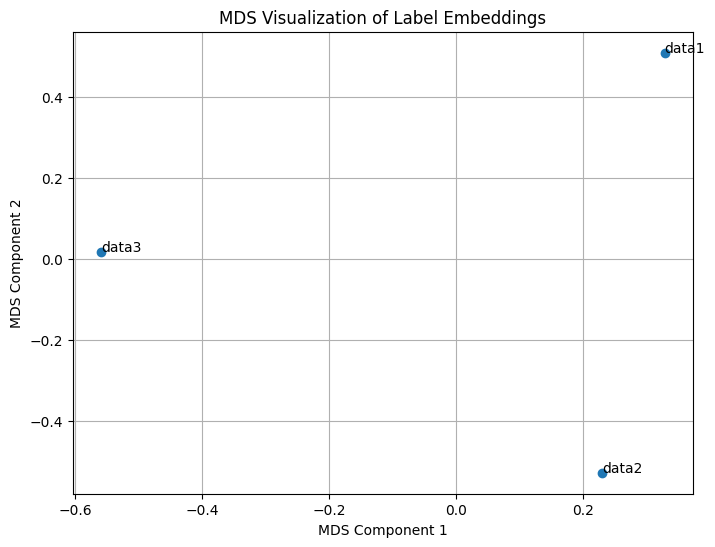

In [ ]:
# Get the label embeddings
m_label_embeddings = m_model.label_emb.detach().cpu().numpy()

# Compute similarity and distance matrices
m_similarity_matrix_labels = cosine_similarity(m_label_embeddings)
m_distance_matrix_labels = 1 - m_similarity_matrix_labels

# Perform MDS on label embeddings
mds_labels = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
m_mds_result_labels = mds_labels.fit_transform(m_distance_matrix_labels)

# Get the labels for plotting (0 and 1 in this case)
m_labels_for_plot = list(range(len(m_label_embeddings)))

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(m_mds_result_labels[:, 0], m_mds_result_labels[:, 1])

# Annotate points with labels
labelled=['data1', 'data2', 'data3']
for i, label in enumerate(m_labels_for_plot):
    plt.text(m_mds_result_labels[i, 0], m_mds_result_labels[i, 1], labelled[label])

plt.title('MDS Visualization of Label Embeddings')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()